# Projet Final INF8225 : Comparaison entre les différentes versions de l'algorithme YOLO pour la détection d'objet
Présenté par : \\
Pierre-Emmanuel Savoie 1952752 \\
Charles Martel 1956295 \\
Lucie Aldebert 2091339 \\
Matthieu Deloffre 2097944

Le but de notre projet est d’implémenter les différentes versions du modèle YOLO appliqué à la détection d’images afin de mesurer la performance et la précision de chacune pour ensuite les comparer entre elles. Pour ce faire, nous utilisons Pytorch pour l'implémentation de notre modèle ainsi que la base de données PascalVOC pour l'entraînement.

Notre projet est séparé en quatre sections, la première concernant les informations utilitaires, soit l'analyse exploratoire de la base de données PascalVOC ainsi que les fonctions qui sont utilisées par les trois versions de l'algorithme YOLO. Par la suite, les trois sections suivantes sont chacunes dédiées à une version de YOLO différente et basées respectivement sur les articles scientifiques suivants :


*   Yolov1 : You Only Look Once: Unified, Real-Time Object Detection (https://arxiv.org/abs/1506.02640,https://arxiv.org/abs/1612.08242)
*   Yolov2 : YOLO9000: Better, Faster, Stronger (https://arxiv.org/abs/1612.08242)
*   Yolov3 : YOLOv3: An Incremental Improvement (https://arxiv.org/abs/1804.02767)

Pour chacun de ces articles, une description brève du fonctionnement ou des améliorations qui sont décrits dans ce dernier est présentée. De plus, chacune de celles-ci est complémentée d'une implémentation détaillée du modèle et d'une section d'expérimentation qui tente d'obtenir les meilleurs résultats en les comparant à ceux obtenus avec les modèles précédents.

Pour la réalisation de ce projet, plusieurs sources externes ont été utilisées. Voici une liste de ces sources avec une courte description de leur utilité : 


1.   https://amrokamal-47691.medium.com/yolo-yolov2-and-yolov3-all-you-want-to-know-7e3e92dc4899 : Blog très informatif qui démontre les principales différences, forces et faiblesses de chaque itérations de l'algorithme YOLO
2.   https://www.youtube.com/watch?v=n9_XyCGr-MI : Un exemple d'implémentation du modèle YOLOv1 avec Pytorch. Ce tutoriel a été grandement utilisé pour la réalisation du modèle YOLOv1. Nous avons principalement adapté ce tutoriel à nos besoins.
3.   https://www.youtube.com/watch?v=Grir6TZbc1M : Un exemple d'implémentation du modèle YOLOv3 avec Pytorch. Ce tutoriel a été grandement utilisé pour la réalisation du modèle YOLOv2 et YOLOv3. Nous avons principalement adapté ce tutoriel à nos besoins.




##Utilité

In [ ]:
import torch
import torchvision
import copy
import torch.nn as nn
import os
import math
import pandas as pd
import torch
import time
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
from google.colab import drive

###Non-Max Suppression

Nous avons besoin d'implémenter la fonction *Non-Max Suppression*, qui permet de supprimer les encadrements redondants autour d'un même objet détecté, comme on peut le voir sur l'image ci-dessous ([Source](https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c)). 

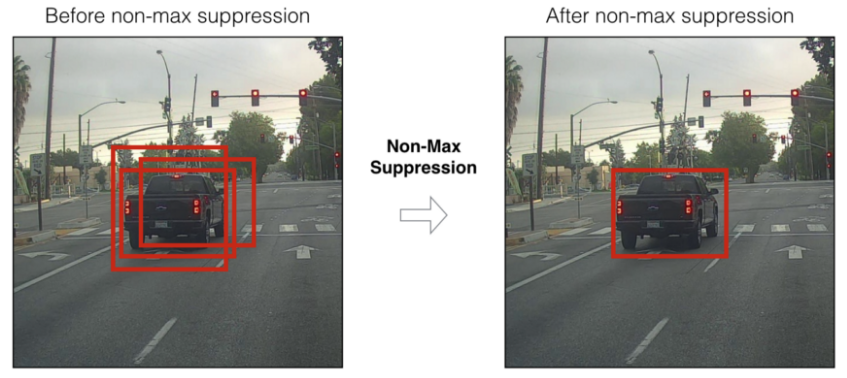

Cette fonction prend donc en arguments *bboxes* toutes les boîtes encadrantes, *box_format* le format de ces dernières ainsi que deux valeurs de seuil différentes, *iou_threshold* le seuil donné par la fonction *intersection_over_union* qui détermine si l'encadrement est correct, et un autre seuil indépendant *threshold* qui permet de supprimer les encadrements redondants. En sortie, on peut donc retrouver une liste d'encadrements après "filtrage" par la Non-Max Suppression. 

In [ ]:
#Non Max suppression
def nms(bboxes, iou_threshold, threshold, box_format = "corners"):
  assert type(bboxes) == list
  bboxes = [box for box in bboxes if box[1] > threshold]
  bboxes = sorted(bboxes, key = lambda x: x[1], reverse = True)
  bboxes_after_nms = []

  while bboxes:
    chosen_box = bboxes.pop(0)

    bboxes = [box for box in bboxes if box[0] != chosen_box[0] or intersection_over_union(torch.tensor(chosen_box[2:]), torch.tensor(box[2:])) < iou_threshold ]

    bboxes_after_nms.append(chosen_box)
  
  return bboxes_after_nms

###Mean Average Precision

Nous avons également besoin d'une fonction permettant de calculer la précision moyenne sur toutes les prédictions. On retrouve en entrées *pred_boxes* la liste des encadrements prédits, *true_boxes* la liste des encadrements réels, *iou_threshold* le seuil à partir duquel un encadrement est considéré juste (toujours déterminé par la fonction *intersection_over_union*), *box_format* le format des boîtes d'encadrement, et finalement *num_classes* le nombre de classes.

In [ ]:
#Mean Average Precision
def map(pred_boxes, true_boxes, iou_threshold = 0.5, box_format = "midpoint", num_classes = 20):
  # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]
            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:])
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)  




Nous avons aussi une fonction pour vérifier la précision de la partie classification ainsi que le pourcentage d'objets détectés et d'objets non détectés.

In [ ]:
def check_class_accuracy(model, loader, threshold=0.5):
    model.eval()
    tot_class_preds, correct_class = 0, 0
    tot_noobj, correct_noobj = 0, 0
    tot_obj, correct_obj = 0, 0

    for x, y in loader:
        x = x.to("cuda")
        with torch.no_grad():
            out = model(x)


        y = y.to("cuda")
        obj = y[..., 0] == 1 # in paper this is Iobj_i
        noobj = y[..., 0] == 0  # in paper this is Iobj_i
        correct_class += torch.sum(
            torch.argmax(out[..., 5:][obj], dim=-1) == y[..., 5][obj]
        )
        tot_class_preds += torch.sum(obj)

        obj_preds = torch.sigmoid(out[..., 0]) > threshold
        correct_obj += torch.sum(obj_preds[obj] == y[..., 0][obj])
        tot_obj += torch.sum(obj)
        correct_noobj += torch.sum(obj_preds[noobj] == y[..., 0][noobj])
        tot_noobj += torch.sum(noobj)

    print(f"Class accuracy is: {(correct_class/(tot_class_preds+1e-16))*100:2f}%")
    print(f"No obj accuracy is: {(correct_noobj/(tot_noobj+1e-16))*100:2f}%")
    print(f"Obj accuracy is: {(correct_obj/(tot_obj+1e-16))*100:2f}%")
    model.train()

### Intersection over union

Intersection over Union, aussi connue sous le nom de IoU, est une mesure pour connaitre la validité d'une bounding box. Pour ce faire, nous avons besoin de la bonne bounding box ainsi que de la prédiction. IoU peut donc ensuite être calculé avec l'intersection des deux bounding box divisée par l'union de ces deux mêmes boites. Cela nous donne donc les meilleurs résultats plus les deux boites sont semblables.

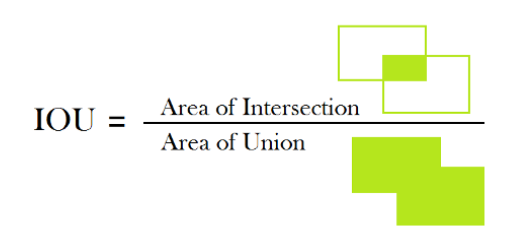

Nous avons besoin de deux fonctions Intersection over union, la première est lorsque les boites on une position en 2 dimension, puisque les deux boites n'ont pas le même centre il faut utiliser les coins pour calculer l'intersection des boites. La deuxième fonction, $iou\_width\_height$ est lorsque les boites n'ont pas de positionnement en deux dimensions, nous pouvons donc assumé qu'ils sont centré et utiliser les valeurs de longeur et largeur seulement. Cette deuxième méthode sera surtout utilisé pour calculer les anchors boxes optimales lors de l'implémentation des datasets pour yolov2 et v3

In [ ]:
def intersection_over_union(boxes_preds, boxes_labels):
    box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
    box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
    box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
    box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
    box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
    box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
    box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
    box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [ ]:
def iou_width_height(boxes1, boxes2):
    intersection = torch.min(boxes1[..., 0], boxes2[..., 0]) * torch.min(
        boxes1[..., 1], boxes2[..., 1]
    )
    union = (
        boxes1[..., 0] * boxes1[..., 1] + boxes2[..., 0] * boxes2[..., 1] - intersection
    )
    return intersection / union

### Conversion functions

Quelques fonctions de conversion. Les prédictions faites par le modèle génère des valeurs relatives à la zone de détection, il faut donc modifier ces valeurs pour qu'elles soient relative a l'image complète avant de pouvoir les afficher. Dans le cas de yolov2 et v3, il y a aussi présence d'anchor boxes, il faut donc rajouter des calculs de conversion pour calculer la largeur et hauteur de la boite.

In [ ]:
#Converts bounding boxes output from Yolo with an image split size of S into entire image ratios rather than relative to cell ratios.
def convert_cellboxes(predictions, S=7):
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat((predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim = 0)
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(-1)
    converted_preds = torch.cat((predicted_class, best_confidence, converted_bboxes), dim = -1)

    return converted_preds
  
def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes


In [ ]:
def cellboxes_to_boxes_with_anchors(predictions, anchors, S, is_preds=True):
    BATCH_SIZE = predictions.shape[0]
    num_anchors = len(anchors)
    box_predictions = predictions[..., 1:5]
    if is_preds:
        anchors = anchors.reshape(1, len(anchors), 1, 1, 2)
        box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2])
        box_predictions[..., 2:] = torch.exp(box_predictions[..., 2:]) * anchors
        scores = torch.sigmoid(predictions[..., 0:1])
        best_class = torch.argmax(predictions[..., 5:], dim=-1).unsqueeze(-1)
    else:
        scores = predictions[..., 0:1]
        best_class = predictions[..., 5:6]

    cell_indices = (
        torch.arange(S)
        .repeat(predictions.shape[0], 5, S, 1)
        .unsqueeze(-1)
        .to(predictions.device)
    )
    x = 1 / S * (box_predictions[..., 0:1] + cell_indices)
    y = 1 / S * (box_predictions[..., 1:2] + cell_indices.permute(0, 1, 3, 2, 4))
    w_h = 1 / S * box_predictions[..., 2:4]
    converted_bboxes = torch.cat((best_class, scores, x, y, w_h), dim=-1).reshape(BATCH_SIZE, num_anchors * S * S, 6)
    return converted_bboxes.tolist()

### Affichage d'images

Nous avons également besoin d'une fonction d'affichage qui permettra d'afficher les encadrements prédits directement sur les images d'origine. On retrouve donc en entrée de *plot_image* deux arguments : *image* l'image d'origine ainsi que *boxes* la liste des encadrements à y afficher.

In [ ]:
def plot_image(image, boxes):
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    for box in boxes:
        box = box[2:]
        assert len(box) == 4
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none"
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

### Logger

In [ ]:
# simple logger to track progress during training
class Logger:
    def __init__(self):
        self.losses_train = []
        self.losses_test = []
        self.accuracies_train = []
        self.accuracies_test = []
        
        self.losses_val = []
        self.accuracies_val = []
        

    def log(self, accuracy_train=0, loss_train=0, accuracy_val=0, loss_val=0 ,accuracy_test=0, loss_test=0):
        self.losses_train.append(loss_train)
        self.accuracies_train.append(accuracy_train)
        self.losses_test.append(loss_test)
        self.accuracies_test.append(accuracy_test)
        self.losses_val.append(loss_val)
        self.accuracies_val.append(accuracy_val)
        
    def getState(self):
        return self.losses_train, self.losses_val, self.accuracies_train, self.accuracies_val

    def setState(self, losses_train, losses_val, accuracies_train, accuracies_val):
        self.losses_train = losses_train
        self.losses_val = losses_val
        self.accuracies_train = accuracies_train
        self.accuracies_val = accuracies_val

    def plot_loss(self, train=True, test=False, val=True):
        if not train and not test:
            raise ValueError("Cannot plot loss because train and test")
        plt.figure()
        if train:
            plt.plot(self.losses_train, label="Train")
        if test:
            plt.plot(self.losses_test, label="Test")
        if val:
            plt.plot(self.losses_val, label="Validation")
        plt.legend(loc='best')
        plt.xlabel("Epoch")
        plt.title("Loss")

    def plot_accuracy(self, train=True, test=False, val=True):
        if not train and not test:
            raise ValueError("Cannot plot accuracy because train and test")
        plt.figure()
        if train:
            plt.plot(self.accuracies_train, label="Train")
        if test:
            plt.plot(self.accuracies_test, label="Test")
        if val:
            plt.plot(self.accuracies_val, label="Validation")
        plt.legend(loc='best')
        plt.xlabel("Epoch")
        plt.title("mean Average Precision")
  
    def print_last():
        print(f"Epoch {len(self.losses_train):2d}, \
                  Train:loss={self.losses_train[-1]:.3f}, accuracy={self.accuracies_train[-1]*100:.1f}%, \
                  Validation: loss={self.losses_val[-1]:.3f}, accuracy={self.accuracies_test[-1]*100:.1f}%", flush=True)

In [ ]:
def timeSince(since):
    now = time.time()
    s = now - since
    ms = math.floor(s % 1 * 1000)
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds %dms' % (m, s, ms)

### Saving & Loading

In [ ]:
drive.mount('/content/gdrive')

def save_checkpoint(model, optimizer, logger, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    path_to_checkpoint = "/content/gdrive/MyDrive/Projet Final IA/Model_checkpoint/"
    losses_train, losses_val, accuracies_train, accuracies_val = logger.getState()
    state = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "logger_losses_train": losses_train,
        "logger_losses_val": losses_val,
        "logger_accuracies_train": accuracies_train,
        "logger_accuracies_val": accuracies_val,
    }
    torch.save(state, path_to_checkpoint + filename)

def load_checkpoint(model, optimizer, logger, filename="my_checkpoint.pth.tar"):
    print("=> Loading checkpoint")
    path_to_checkpoint = "/content/gdrive/MyDrive/Projet Final IA/Model_checkpoint/"
    checkpoint = torch.load(path_to_checkpoint + filename)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    logger.setState(checkpoint["logger_losses_train"],checkpoint["logger_losses_val"],checkpoint["logger_accuracies_train"],checkpoint["logger_accuracies_val"])

Mounted at /content/gdrive


## YOLOv1

###Dataset


Le modèle YOLO traite une image comme une grille de cellules. Un objet va donc être détecté par une cellule spécifique lorsque son point milieu se trouve au sein de celle-ci. Le but de ce module est donc de convertir les données de PascalVOC en un format facilement utilisable par YOLO.

L'accès à tout élément de la base de données choisie nous donne une paire (image, label). L'image devra être transformée en tenseur de pixels 448 x 448, tel qu'indiqué par le papier. Le modèle va "downscale" cet objet par un facteur de 32 afin de générer un "feature map" 14 x 14.

Un label décrit un objet détecté dans une image et est représenté par un dictionnaire dans le code qui suit. On y trouve notamment la taille de l'image et la liste d'objets détectés, chacun indiquant la classe et les dimensions de l'objet en question.

Il est important de noter que les valeurs numériques d'un label sont toutes relatives à l'image au complet. YOLO nécessite, pour chaque cellule qui contient un objet, que les valeurs numériques de cet objet soient relatives à la cellule plutôt qu'à l'image complète.

Soit $S$ la variable qui définit la taille de la grille. Nous voulons générer une matrice $S$ x $S$ x $25$ afin de storer ces valeurs. la troisième dimension correspond au label d'une cellule:
* $label$ [0, 19] : Chaque index correspond à une classe.
* $label$ [20] : Probabilité que la cellule contienne un objet.
* $label$ [21, 24] : Variables $x$, $y$, $w$ et $h$ à l'échelle de la cellule.



In [ ]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img= t(img)
        return img

class PascalVOC_DataSet(torch.utils.data.Dataset):
  def __init__(self, test = False, S=7, B=2, C=20):
    self.classes = []
    self.transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])
    self.image_set = "val" if test else "train"
    self.dataset = torchvision.datasets.VOCDetection(root = "./", year = '2012', image_set = self.image_set, download = True, transform=self.transform)
    self.S = S # grid size
    self.B = B # number of bounding boxes per cell
    self.C = C # number of classes
    
  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, index):
    image, labels = self.dataset[index]

    # generate bounding boxes from the labels
    bounding_boxes = []
    size = labels["annotation"]["size"]
    for obj in labels["annotation"]["object"]:
      bounding_box = []
      obj_coords = obj["bndbox"]
      bounding_box.append(obj["name"]) # class_label
      bounding_box.append(((float(obj_coords["xmin"]) + float(obj_coords["xmax"])) / 2) / float(size["width"])) # x
      bounding_box.append(((float(obj_coords["ymin"]) + float(obj_coords["ymax"])) / 2) / float(size["height"])) # y
      bounding_box.append((float(obj_coords["xmax"]) - float(obj_coords["xmin"])) / float(size["width"])) # width
      bounding_box.append((float(obj_coords["ymax"]) - float(obj_coords["ymin"])) / float(size["height"])) # height
      bounding_boxes.append(bounding_box)
    
    # convert labels to matrix of target shape (S, S, 25)
    label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
    for box in bounding_boxes:
      class_label, x, y, width, height = box
      # get the indexes of the cell
      i, j = int(self.S * y), int(self.S * x)
      # get label content relative to the cell at (i, j)
      x_cell, y_cell = self.S * x - j, self.S * y - i
      width_cell, height_cell = width * self.S, height * self.S

      # store label content in matrix
      if label_matrix[i, j, 20] == 0:
        label_matrix[i, j, 20] = 1 # P(Cell [i, j] contains an image)
        box_coordinates = torch.tensor([x_cell, y_cell, width_cell, height_cell])
        label_matrix[i, j, 21:25] = box_coordinates # unpack coordinates
        if class_label in self.classes :
          label_matrix[i, j, self.classes.index(class_label)] = 1
        else :
          label_matrix[i, j, len(self.classes)] = 1
          self.classes.append(class_label)
    
    return image, label_matrix

In [ ]:
dataset_train = PascalVOC_DataSet()
#dataset_test = PascalVOC_DataSet(test=True)


Extracting ./VOCtrainval_11-May-2012.tar to ./


In [ ]:
print(f"The Trainning dataset containt {len(dataset_train)} examples")
#print(f"The Test dataset containt {len(dataset_test)} examples")

The Trainning dataset containt 5717 examples


###Architecture du modèle


La force principale de l'algorithme Yolo est que celui-ci passe seulement une seule fois sur l'image, alors que les algorithmes précédents devaient passer au travers de l'image plusieurs fois. Le principe fondamental de l'algorithme YOLO est de diviser l'image en $S \times S$ zone de détections. L'image ci-dessous démontre un exemple avec une valeur $S = 7$.

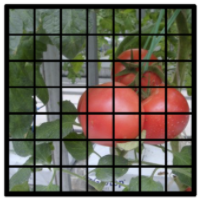


Par la suite, chaque zone de détection est responsable de créer un certain nombre $B$ de bounding box et d'accorder une probabilité qu'il s'agisse d'un objet à ces boites. Chaque boite est définie par sa position $(x,y)$ relative à la zone de détection ainsi sa largeur et hauteur, aussi relative à la zone de détection. De ce fait, la zone de détection qui est responsable de la détection d'un objet est celle dont le centre de l'objet (centre de la bounding box) est dans la zone de détection. Nous pouvons voir un exemple ci-dessous avec toutes les bounding box générées par les zones de détections.

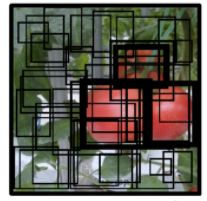

Finalement, en utilisant l'algorithme de non-maximal suppression, nous sommes capables de choisir et garder seulement les meilleurs bounding boxes. En utilisant l'exemple précédent, nous obtenons maintenant une bonne détection d'objets.

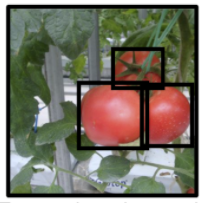

L'algorithme YOLOv1 contient cependant quelques limitations. Cela est dû au fait que seulement un objet peut être identifié par chaque zone de détection, cela fait en sorte que si deux objets se trouvent dans la même zone de détection seul un des deux sera identifié. Cela pose un problème lors de la détection de petits objets qui sont très rapprochés ou d'objets superposés. Ce problème d'ailleurs réglé par les prochaines versions de YOLO qui permettront au zones de détecter plusieurs objects différents.

Pour l'architecture du modèle, nous allons reproduire l'architecture qui est proposée dans l'article de recherche et que nous pouvons voir ci-dessous. Nous allons donc avoir 24 couches convolutionnelles suivies de deux couches complètement connectées. 

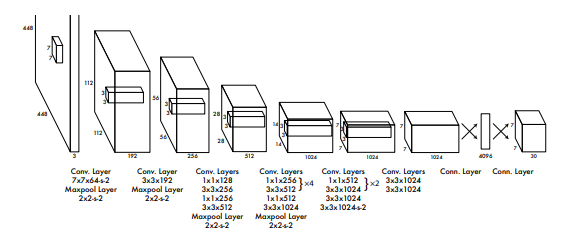

Dans le but de faire une architecture qui peut être modifiée facilement, nous allons créer le modèle à partir d'une liste de config qui va servir à la spécification de la partie convolutionnelle du modèle. Cette liste de config peut contenir trois type d'éléments : 


1.   Un tuple, qui représente une couche convolutionnelle, de la forme (kernel_size, num_channels, stride, padding)
2.   Une string de la forme "Max Pooling" qui représente une couche de max pooling.
3.   Une liste contenant un ou plus tuple suivit d'un nombre entier. Il s'agit d'une répétition de plusieurs couche convolutionnelle. Les tuples représentent les couches à répéter et le nombre entier, le nombre de répétitions.



In [ ]:
yolov1_architecture = [
    (7, 64, 2, 3),
    "Max Pooling",
    (3, 192, 1, 1),
    "Max Pooling",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "Max Pooling",
    [(1, 256, 1, 0),(3, 512, 1, 1),4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "Max Pooling",
    [(1, 512, 1, 0),(3, 1024, 1, 1),2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    [(3, 1024, 1, 1),2],
] 

Nous voulons ensuite définir ce que nous attendons d'une couche convolutionnelle. Dans l'article de YoloV1, une couche CNN contient donc simplement une convultion en deux dimensions suivit d'une fonction d'activation, nous avons décidé d'ajouter de la batch normalization avant l'activation, car sans cela notre modèle avait enormement de problèmes lors de l'entrainement. Pour la fonction d'activation, nous allons utiliser la même que dans l'article, soit une leaky ReLU avec paramètre 0.1.

In [ ]:
class CNNLayer(nn.Module):
  def __init__(self, in_channels, kernel_size, out_channels, stride, padding):
    super(CNNLayer, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    self.batchnorm = nn.BatchNorm2d(out_channels)
    self.activation = nn. LeakyReLU(0.1)

  def forward(self, x):
    return self.activation(self.batchnorm(self.conv(x)))

Le modèle YoloV1 est notre implémentation de l'article "You Only Look Once : Unified, Real-Time Object Detection". Notre modèle à besoin de 6 hyper-paramètres différents :


1.   $conv\_config$ : architecture de la partie convultionnelle du modèle (définition et explication plus haut)
2.   $split\_size$ ($S$ dans l'article) : nombre de subdivision horizontale et verticale de l'image pour la détection, il au aura $S^2$ zones de détections. Si aucune valeur n'est fournie, on utilise la même valeur que dans l'article, soit 7.
3.   $num\_box$ ($B$ dans l'article) : nombre de bounding boxes produites par chaque zone de détection. Dans l'article, une valeur par de 2 est utilisé, cela est donc notre valeur par défaut.
4.   $num\_classes$ ($C$ dans l'article) : nombre de classes, si aucune valeur n'est spécifiée, la valeur par défaut est de 20 (ce qui correspond au nombre de classes dans le dataset Pascal VOC).
5.   $num\_units$ : Nombre d'unités de l'avant dernière couche connectée. Cette couche peut avoir un nombre arbitraire d'unitées, l'article utilise 4096 unités, mais nous allons probablement devoir utiliser un nombre plus petit pour réduire le temps d'entrainement. Valeur par défaut de 4096. 


La fonction forward retourne les prédictions sous la forme suivante : $(batch\_size, split\_size, split\_size, num\_classes + num\_box * 5)$.

Pour chaque zone de détection nous avons donc un vecteur de la forme $(C_1, ... , C_{20}, P_1, x_1, y_1, w_1, h_1, P_2, x_2, y_2, w_2, h_2)$ où :


*   $C_1-C_20$ : 20 classes possibles du Pascal VOC dataset
*   $P_i$ : probabilité que la bounding box $i$ soit correct   
*   $x_i$ : position en x du centre de la bounding box relatif à la zone de détection (entre $0.0$ et $1.0$)   
*   $y_i$ : position en y du centre de la bounding box relatif à la zone de détection (entre $0.0$ et $1.0$)   
*   $w_i$ : largeur de la bounding box relatif à la zone de détection, donc une valeur de $1.0$ est égale à la largeur de la zone de détection.
*   $h_i$ : hauteur de la bounding box relatif à la zone de détection, donc une valeur de $1.0$ est égale à la largeur de la zone de détection.





In [ ]:
class YoloV1(nn.Module):
  def __init__(self, conv_config = yolov1_architecture, split_size = 7, num_box = 2, num_classes = 20, num_units = 496):
    super(YoloV1, self).__init__()
    self.conv_config = conv_config
    self.in_channels = 3
    self.conv_net = self._init_conv_net()
    self.connected_layers = self._init_connected_layers(split_size, num_box, num_classes, num_units)

  def forward(self, x):
    x = self.conv_net(x)
    x = torch.flatten(x, start_dim=1)
    return self.connected_layers(x)

  #Initialisation de la partie convultionnelle du modèle en fonction de la configuration
  def _init_conv_net(self):
    layers = []
    in_channels = self.in_channels
    conv_config = copy.deepcopy(self.conv_config)

    for layer in conv_config :
      if type(layer) == tuple:
        layers += [CNNLayer(
            in_channels = in_channels,
            kernel_size = layer[0],
            out_channels = layer[1],
            stride = layer[2],
            padding = layer[3], 
            )]
        in_channels = layer[1]
      elif type(layer) == str:
        layers += [nn.MaxPool2d(kernel_size=2, stride = 2)]
      
      elif type(layer) == list:
        num_reps = layer[len(layer)-1]
        layer.remove(num_reps)

        for _ in range(num_reps):
          for i in layer:
            layers += [CNNLayer(
              in_channels = in_channels,
              kernel_size = i[0],
              out_channels = i[1],
              stride = i[2],
              padding = i[3], 
            )]

            in_channels = i[1]

    return nn.Sequential(*layers) 

  # Initialisation de la partie complètement connectée du modèle
  def _init_connected_layers(self, S, num_box, num_classes, num_units):
    S, B, C = S, num_box, num_classes
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(1024 * S * S, num_units),
        nn.LeakyReLU(0.1),
        nn.Linear(num_units, S * S * (C + B * 5))
    )

###Loss Function

La fonction de perte utilisée est la somme des erreurs au carré. Dans le cadre de yolo, l'article utilise une fonction de perte très compliqué que nous pouvons voir ici :

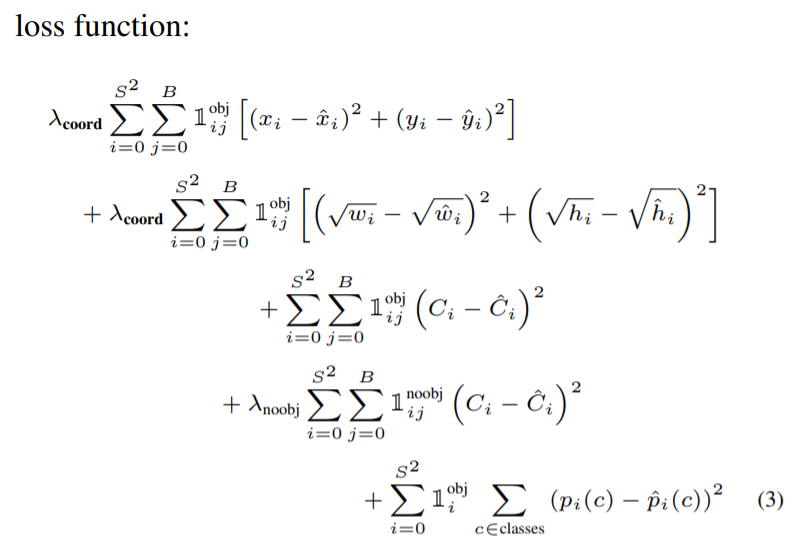

Cette fonction contient deux hyperparamètres, soit $\lambda_{coord}$ et $\lambda_{noobj}$ qui seront initialiés par défaut à 5 et 0.5 respectivement, puisque ce sont les valeurs utilisées dans l'article. Ces hyperparamètres sont utilisé pour augmenter ou diminuer l'impacte de certaines partie de la fonction de perte.

Tout d'abbord, la fonction de perte prend seulement une seule boite de prédiction alors que nous en générons $B = 2$ lors de nos prédictions. Pour choisir quel boit nous allons utiliser comme prédiction, nous allons choisir celle qui contient la plus grande valeur d'interserction over union (IoU) avec la boite cible.

Nous pouvons ensuite séparer la fonction de perte en 4 parties représentant 4 fonctions de perte. La partie 1 est une fonction de perte sur la localisation de la boite, les parties 2 et 3 sur la confiance de la boite et la partie 4 sur la classification.

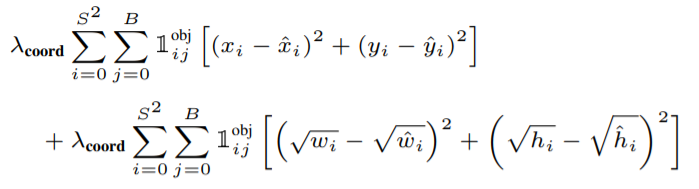

La partie 1 contient deux termes et calcul la perte par rapport à la position et les dimensions des boites. Le premier termes est par rapport au position $(x, y)$ du centre de la boite alors que le deuxième terme est par rapport aux dimensions de hauteur et largeur de la boite. La somme des erreurs carré est calculer pour chacune des $S\times S$ zones de détections et multiplier par 1 s'il y a un objet dans cette zone ou 0 autrement. Le but est de ne pas pénaliser une zone lorsqu'il n'y avait pas d'objet à détecter. Ce sera plutôt la troisième partie de la fonction de perte qui s'occupera de cela par la suite. Finalement, on multiplie cette partie de la fonction de perte par l'hyperparamètre $\lambda_{coord}$ pour augmenter sont impacte par rapport au reste de la fonction de perte.

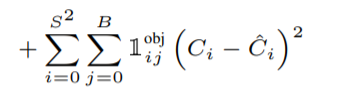

La deuxième partie de la fonction de perte est une fonction de perte pour la confiance qu'il se trouve une objet dans la zone de détection. Cela est donc en fonction du paramètre $C$. Il s'agit donc encore d'une somme des erreurs carré, mais cette fois-ci en fonction du taux de confiance. Tous comme la partie précédente, la somme des erreurs carré est calculer pour chacune des $S\times S$ zones de détections et multiplier par 1 s'il y a un objet dans cette zone ou 0 autrement. Puisque nous regardons seulement les zones avec un objet, la valeur cible de $C$ est donc de $1$.

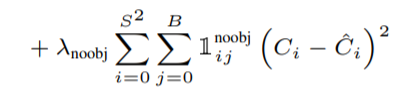

La troisième partie est très similaire à la deuxième, mais cette fois pour les zones de détection qui ne contiennent pas d'objet. La valeur cible de $C$ est donc $0$ plutôt que $1$. Cette partie de la fonction de perte sert à pénaliser le modèle lorsqu'il prédit un objet lorsqu'il n'y en a pas. Comme mentionner précédement, tout cela est multiplier par l'hyperparamètre $\lambda_{noobj}$ pour diminuer un peu son impacte par rapport au reste de la fonction de perte.

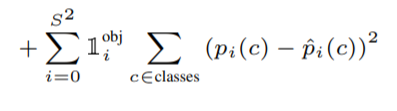

La dernière partie de la fonction de perte est une somme des erreurs carré sur une classification. Il s'agit donc sensiblement de la même fonction que nous avons utilisé lors des deux premiers laboratoire, mais calculer par rapport à chaque zone de détection qui contient un objet.

In [ ]:
class YoloLoss(nn.Module):

  def __init__(self, split_size=7,num_boxes=2, num_classes=20):
    super(YoloLoss, self).__init__()
    self.mean_square_error=nn.MSELoss(reduction="sum")
    self.split_size=split_size
    self.num_boxes=num_boxes
    self.num_classes=num_classes

    #loss parameters
    self.lambda_noobj=0.5
    self.lambda_coord=5


  def forward(self, predictions, target):
    #(batch_size, S*S(C+B*5))-> (S*S(C+B*5))
    batch_size = predictions.shape[0]
    predictions =predictions.reshape(-1,self.split_size,self.split_size,self.num_classes+self.num_boxes*5) 

    #Prediction format
    #0 to 19 classes probability 
    #20 classes score b1
    #21 to 24 four side of bounding box 1
    #25 classes score b2
    #26 to 29 box 2 four side of bounding box 2
    iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
    iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
    ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

    #The loss is only calculate on the box who have the max IoU
    #best_box=0 ->b1 is the best box
    #best_box=1 ->b2 is the best box
    iou_max, best_box= torch.max(ious,dim=0)
    
    #identity of object_i
    exists_box = target[...,20].unsqueeze(3) 

    ##1##
    #Box loss
    box_predictions= exists_box *( 
        best_box * predictions[...,26:30] 
        + (1- best_box) *predictions[...,21:25]) 
    
    box_targets= exists_box * target[...,21:25]
    box_predictions[...,2:4]= torch.sign(box_predictions[...,2:4])*torch.sqrt(torch.abs(box_predictions[...,2:4] + 1e-6))
    box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

    box_loss= self.mean_square_error(
        torch.flatten(box_predictions,end_dim=-2),
        torch.flatten(box_targets,end_dim=-2),
    )

    ##2##
    #For object loss
    pred_box=(
        best_box *predictions[...,25:26] +(1-best_box)* predictions[...,20:21]
    )
    object_loss=self.mean_square_error(
        torch.flatten(exists_box*pred_box),
        torch.flatten(exists_box*target[...,20:21]),
    )

    ##3##
    #No object loss
    no_object_loss=self.mean_square_error(
        torch.flatten((1-exists_box)*predictions[...,20:21], start_dim=1),
        torch.flatten((1-exists_box)*target[...,20:21], start_dim=1),
    )

    no_object_loss+=self.mean_square_error(
        torch.flatten((1-exists_box)*predictions[...,25:26], start_dim=1),
        torch.flatten((1-exists_box)*target[...,20:21], start_dim=1),
    )

    ##4##
    #class loss
    class_loss=self.mean_square_error(
        torch.flatten(exists_box*predictions[...,:20], start_dim=-2),
        torch.flatten(exists_box*target[...,:20], start_dim=-2),
    )
    
    #Total loss
    loss=(
        self.lambda_coord*box_loss
        +object_loss
        +self.lambda_noobj*no_object_loss
        +class_loss

    )

    return loss

### Entrainement

Il nous reste maintenant à s'atteler à l'entraînement de notre modèle. Pour ce faire, on a la fonction *get_bboxes* qui s'occupera de faire l'entraînement du modèle, en comprenant également la *non max suppression* qui a déjà été évoquée à plusieurs reprises. On y retrouve en entrée : 


1.   *loader* qui correspond à notre Data Loader pour récupérer les données.
2.   *model*, le modèle que nous utilisons, ici YoloV1.
3.   *iou_threshold* et *threshold* les deux seuils utilisés dans les fonctions annexes et notamment pour la *Non max suppression*. 
4.   *pred_format* et *box_format* qui correspondent aux formats des encadrements prédits et réels.

L'algorithme retournera deux listes, contenant l'ensemble des prédictions, ainsi que l'ensemble des vraies valeurs. Ces listes vont pouvoir ensuite être comparées dans la fonction *mean_average_precision* pour déterminer la précision des prédictions.



In [ ]:
def get_bboxes_yolov1(loader, model, iou_threshold = 0.5, threshold = 0.4, train = False, optimizer = None, loss_fn = None ,pred_format="cells", box_format="midpoint", device="cuda"):
    all_pred_boxes = []
    all_true_boxes = []

    train_idx = 0

    DEVICE = "cuda" if torch.cuda.is_available else "cpu"
    mean_losses = []
    model=model.cuda()

    startTime = time.time()
    num_iterations = len(loader)
    i = 1

    for x, y in loader:
        if train : 
          print("\rTraining :", end='')
        else : 
          print("\rValidation :", end='')
        print(f"  {int(i/num_iterations*100)}% -- {i}/{num_iterations} iterations -- {timeSince(startTime)}", end = ' ')
        i += 1
        x, y= x.to(DEVICE), y.to(DEVICE)
        predictions = model(x)
        loss = loss_fn(predictions, y)
        mean_losses.append(loss.item())
        if train :
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(y)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = nms(bboxes[idx], iou_threshold=iou_threshold, threshold=threshold, box_format=box_format)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1
        del x
        del y
    
    print("")
    average_mean_loss = sum(mean_losses)/len(mean_losses)

    return all_pred_boxes, all_true_boxes, average_mean_loss

La fonction trainYoloV1 ci-dessous s'occupe de l'entrainement d'un modèle YoloV1. Cette fonction prend les paramètres suivants : 


*   $dataset$ : le jeu de donnée d'entrainement, celui-ci sera séparé en ensemble d'entrainement et de validation.
*   $n\_epoch$ : le nombre d'epoch a effectuer
*   $learning\_rate$ : taux d'apprentissage à utiliser lors de l'entrainement
*   $batch\_size$ : le batch size pour l'initialisation du dataloader
*   $split\_size$ : Paramètre $S$ de l'architecture Yolo pour déterminer le nombre de zones de détections
*   $load\_model$ : spécifie si on veut continuer l'entrainement d'un modèle existant ou commencer un nouveau modèle
*   $load\_file$ : si $load\_model$ est $True$, le fichier ou trouver les informations du modèle



In [ ]:
def trainYoloV1(dataset, n_epochs = 50, learning_rate = 2e-4, batch_size = 16, split_size = 7, load_model = False, load_file = "my_checkpoint.pth.tar"):

    DEVICE = "cuda" if torch.cuda.is_available else "cpu"

    seed = 123
    torch.manual_seed(seed)

    # Initialise model, optimizer and loss function
    model = YoloV1(split_size= split_size, num_box=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=learning_rate,
    )
    loss_fn = YoloLoss()

    # Separate the training set into training and validation set   
    len_train = int(len(dataset)*0.8)
    len_val = len(dataset) - len_train
    dataset_train, dataset_val = random_split(dataset, [len_train, len_val])
    train_loader = DataLoader(
        dataset=dataset_train,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=True,
    )
    val_loader = DataLoader(
        dataset=dataset_val,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=True,
    )
    
    
    best_model = model
    best_val_loss = 0
    logger = Logger()

    start_epoch = 0
    if load_model:
        load_checkpoint( model, optimizer, logger, load_file)
        start_epoch = len(logger.losses_train)
    
    for epoch in range(start_epoch, n_epochs + start_epoch):
        print(f"---EPOCH {epoch}---")
        pred_boxes, target_boxes, loss_train = get_bboxes_yolov1(
            train_loader, model, train = True, optimizer = optimizer, loss_fn = loss_fn
        )
        pred_boxes_val, target_boxes_val, loss_val = get_bboxes_yolov1(
            val_loader, model, train = False, optimizer = optimizer, loss_fn = loss_fn
        )

        mean_avg_prec_train = map(pred_boxes, target_boxes)
        mean_avg_prec_val = map(pred_boxes_val, target_boxes_val)
        
       
        if loss_val >= best_val_loss:
            best_model = model
            best_val_loss=loss_val
        
        logger.log(accuracy_train=mean_avg_prec_train, loss_train=loss_train, accuracy_val=mean_avg_prec_val, loss_val=loss_val)
        
        print(f"training set loss: {loss_train:.4f}\t\t\tvalidation set loss: {loss_val:.4f}")
        print(f"training set accuracy: {mean_avg_prec_train}\t\tvalidation set accuracy: {mean_avg_prec_val}")
    
    print("--Training Complete--")
    return best_model, best_val_accuracy, logger, optimizer

###Expérimentation

Pour la section expérimentation, nous avons décidé d'entrainer le modèle sur différent jeu de données avec différent taux d'apprentissage. Pour chacune de nos expériences, nous avons entrainé le modèle pendant 150 epochs avec un batch size de 16. Nos première expériences étaient avec le jeu de donnée PascalVOC 2007 et avec les taux d'apprentissages de 1e-4 et 1e-5. Nous avons obtenu les résultats suivants : 

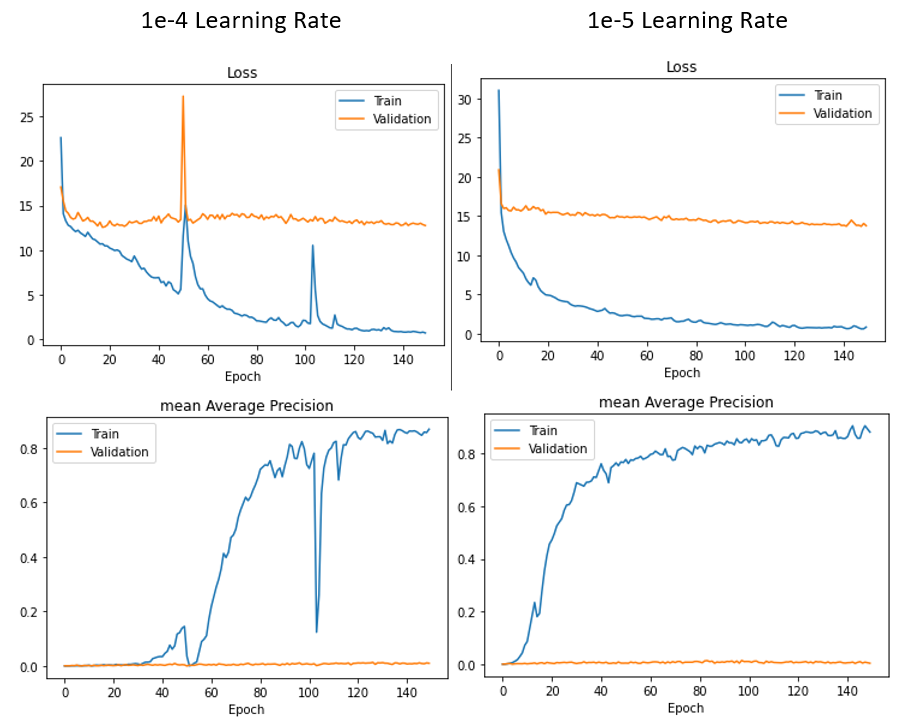

En évaluant les résultats sur l'ensemble d'entrainement, nous pouvons voir que nous sommes capable d'atteindre une très bonne précision. Voici donc un petit tableau démontrant les meilleures valeurs de la fonction de perte et de précisions atteintes avec ces modèles:

Learning rate       |  1e-4   |   1e-5   
--------------------|----------|--------
**Loss**            |  0.6959  |  0.5906   
**Accuracy**        |  0.8677  |  0.9052

Une précision de 90% est très bonne, cependant cela est sur l'ensemble d'entrainement. Lorsque nous regardons les graphiques, nous pouvons rapidement voir que le modèle ne performe pas aussi bien sur l'ensemble d'entrainement. En effet, celui-ci n'as pas l'air de s'améliorer aucunement durant l'entrainement. Notre première hypothèse était qu'il n'y avait peut-être pas assez de données dans l'ensemble d'entrainement et il devenait facile d'overfit ces données. En effet, le jeu de donnée de 2007 est beaucoup plus petit que le jeu de donnée 2012. Nous avons donc effectuer les mêmes expériences sur le jeu de doonnée PascalVOC en espèrant obtenir des meilleurs résultats sur l'ensemble de validation.

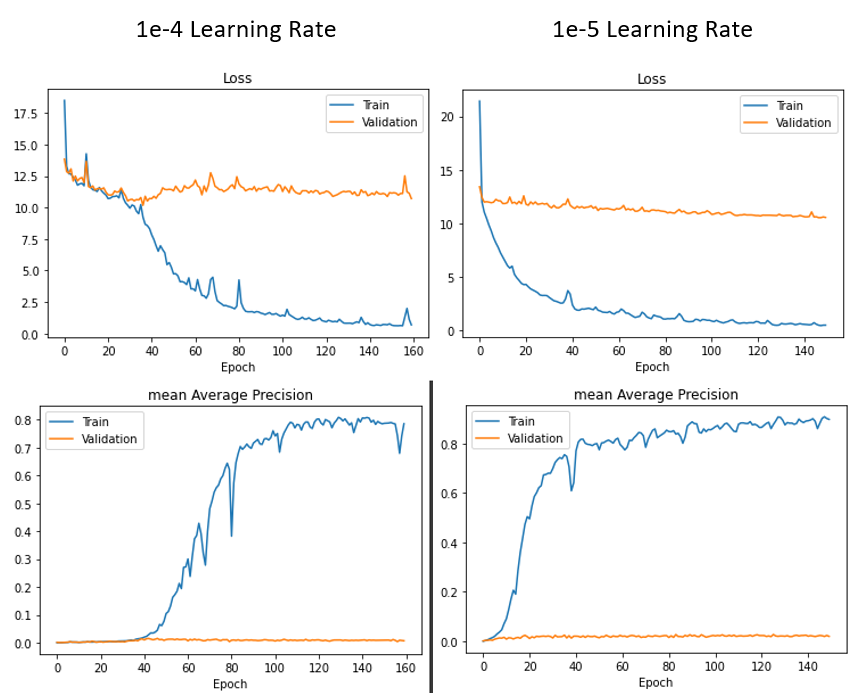

Sur le jeu de donnée PascalVOC 2012, nous obtenons des résultats très similaire au résultats précédents :

Learning rate       |  1e-4 |   1e-5   
--------------------|----------|--------
**Loss**            |  0.6132  |  0.4293
**Accuracy**        |  0.8088  |  0.9078

Cependant, cela ne règle pas du tout notre problème avec l'ensemble de validation. En effet, encore une fois, notre modèle devient vraiment bon à prédire sur des images qu'il à déjà vu mais ne perfome pas du tout sur de nouvelles images. Nous sommes donc retourner à l'article de YOLO pour identifier les étapes prises pour contrer le problème d'overfitting :


> "To avoid overfitting we use dropout and extensive data
augmentation. A dropout layer with rate = .5 after the first
connected layer prevents co-adaptation between layers [18].
For data augmentation we introduce random scaling and
translations of up to 20% of the original image size. We
also randomly adjust the exposure and saturation of the image by up to a factor of 1.5 in the HSV color space."

Nous avons donc tenter une dernière expérimentation en ajoutant cette couche de dropout juste avant la dernière couche complètement connecté. Nous avons aussi utilisé un taux d'apprentissage de 1e-5 puisque c'est celui qui semblait le mieux fonctionner lors des expériences précédentes.


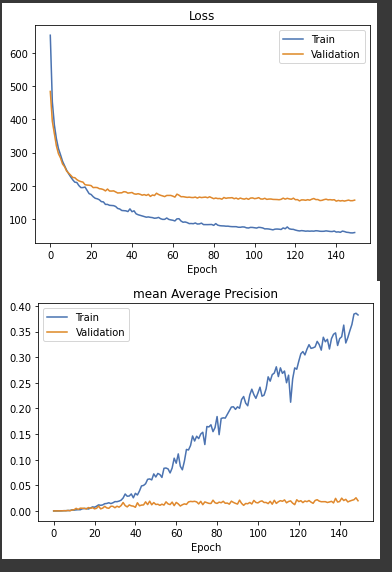

Malheureusement, l'ajout de dropout semble seulement nuire à l'apprentissage du modèle, car en utilisant le même nombre d'epochs que précédement, nous atteignons des résultats significativement inférieurs.

Nous pensons pouvoir voir quelques causes à ce problème d'overfitting que nous ne sommes pas capable de résoudre. Premièrement le modèle YOLO présenté dans l'article utilise de l'augmentation de données, ce qui aide à reduire le risque d'overfitting. Deuxièmement, dans l'article, le modèle est pre-entrainé pour la classification sur le jeu de donnée ImageNet. Cette étape de pré-entrainement semble cruciale à l'entrainement du modèle Yolo et l'absence de ce pré-entrainement est peut-être la raison pour laquelle notre modèle ne performe pas aussi bien sur le modèle de validation.

Pour appronfondir avoir une meilleur idée des résultats avec l'algorithme YoloV1, avons quelques exemples de images et de détections d'objets qui mettront en valeur les succès et les échecs de notre implémentation. Commençons avec les succès, nous pouvons voir ci-dessous la détection parfaite de l'humain et du cheval dans la première photo et un oiseau dans la deuxième.

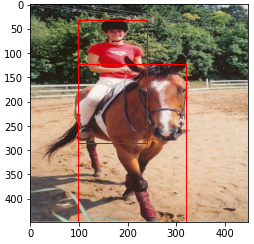

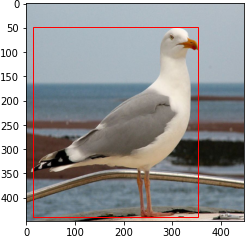

L'exemple ci-dessous est très impressionant, car nous avons mentionner que la première version de l'algorithme Yolo peut avoir de la difficulté à détecté des objets rapprochés ou de petite taille. L'image ci-dessous présente des humains dans un chariot, l'algorithme réussit à détecter tous les humains ainsi que le cheval, bien que les humains dans le chariot sont rapproché et que leurs corps est partiellement caché.

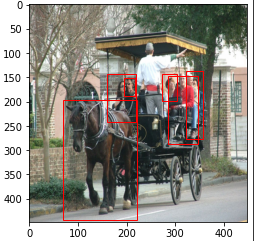

Nous avons aussi deux exemples de erreurs potentielles de notre modèle. En premier lieu, il n'y a tout simplement aucune détection dans la photo, alors que le chat est très évident. En deuxième lieu, bien que le chat est correctement identifié, la boite englobante est de mauvaise taille.

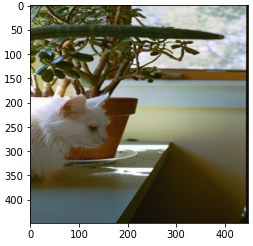

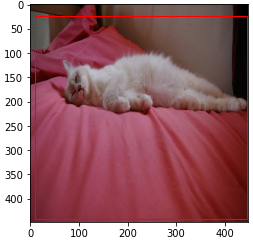

## YOLOv2

###Dataset


YOLOv2 introduit le concept des "Anchor Boxes" dans l'algorithme. En assignant 5 boîtes d'ancrage pour chaque cellule de la grille S x S, on génère désormais une prédiction sur la probabilité de classe et d'objet pour chaque boîte au lieu de chaque cellule, ce qui permet deux choses :

*   On peut maintenant détecter plus d'un objet par cellule (maximum de 5 dans le papier).
*   Chaque boîte d'ancrage a une dimension prédéfinie. Celle-ci se modifie à chaque fois que la boîte correspondante est identifiée comme responsable du bounding box d'un objet détecté. Ceci permet au modèle de reconnaître plus rapidement un certain objet puisque ses anchor boxes détiennent des connaissances antérieures qui aident à prédire les formes les plus fréquentes qui sont identifiées.

Ce faisant, on doit trouver la meilleure boîte pour chaque bounding box d'une cellule si celle-ci contient un objet. Pour ce faire, on calcule le IoU de chaque anchor box avec chaque bounding box et on prend les paires avec le meilleur score.

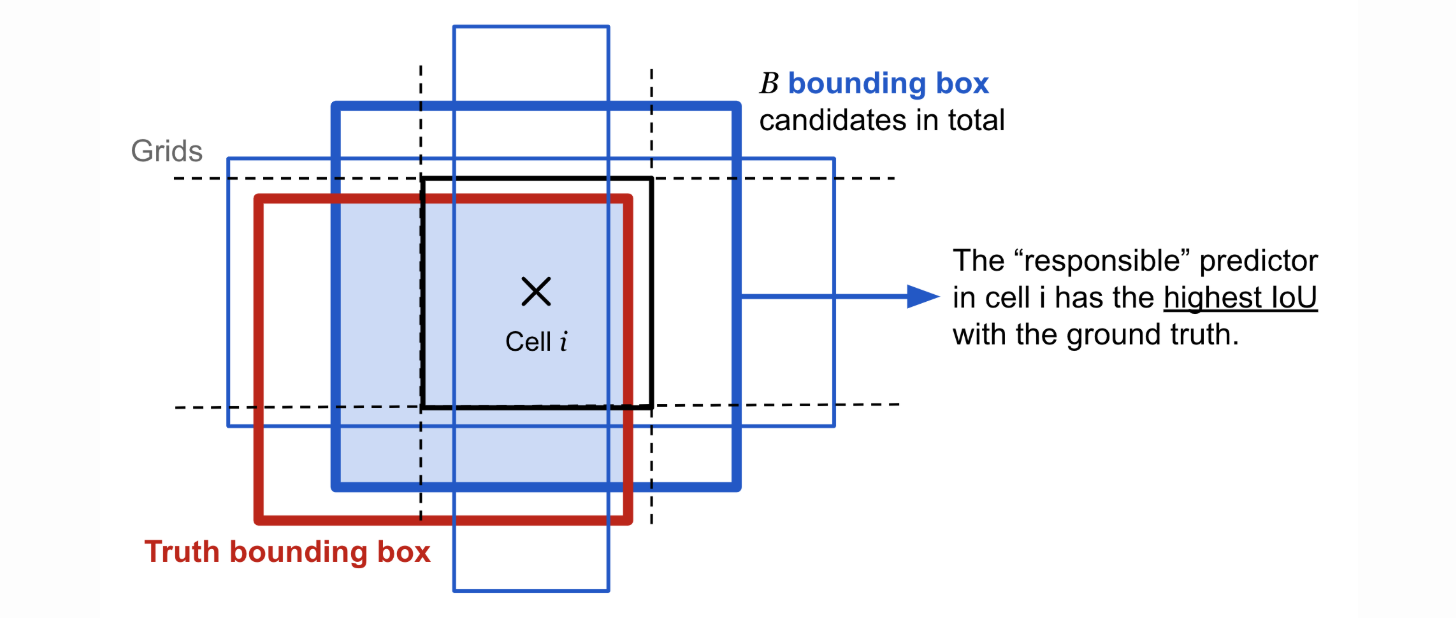

De plus, on utilise une résolution de 416 x 416 afin d'obtenir une image 13 x 13 lorsque les CNN de YOLO sous-échantillonnent celle-ci par un facteur de 32. Les auteurs du papier créditent ce changement pour avoir amélioré la performance de l'algorithme puisque le fait d'avoir une cellule en plein milieu de l'image permet de mieux reconnaître les gros objets qui ont tendance à occuper le centre de l'image.

In [ ]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img= t(img)
        return img

class PascalVOC_DataSet(torch.utils.data.Dataset):
  def __init__(self, anchors, test = False, S=13, C=20):
    self.classes = []
    self.transform = Compose([transforms.Resize((416, 416)), transforms.ToTensor(),])
    self.image_set = "val" if test else "train"
    self.dataset = torchvision.datasets.VOCDetection(root = "./", year = '2012', image_set = "train", download = True, transform=self.transform)
    self.anchors = torch.tensor(anchors)
    self.num_anchors = self.anchors.shape[0]
    self.S = S # grid size
    self.C = C # number of classes
    self.ignore_iou_thresh = 0.5
    
  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, index):
    image, labels = self.dataset[index]

    # generate bounding boxes from the labels
    bounding_boxes = []
    size = labels["annotation"]["size"]
    for obj in labels["annotation"]["object"]:
      bounding_box = []
      obj_coords = obj["bndbox"]
      bounding_box.append(obj["name"]) # class_label
      bounding_box.append(((float(obj_coords["xmin"]) + float(obj_coords["xmax"])) / 2) / float(size["width"])) # x
      bounding_box.append(((float(obj_coords["ymin"]) + float(obj_coords["ymax"])) / 2) / float(size["height"])) # y
      bounding_box.append((float(obj_coords["xmax"]) - float(obj_coords["xmin"])) / float(size["width"])) # width
      bounding_box.append((float(obj_coords["ymax"]) - float(obj_coords["ymin"])) / float(size["height"])) # height
      bounding_boxes.append(bounding_box)
    
    # convert labels to matrix of target shape (num_anchors, S, S, 6)
    label_matrix = torch.zeros((self.num_anchors, self.S, self.S, 6)) # p_o, x, y, w, h, c
    for box in bounding_boxes:

      # sort anchors by their iou wrt. the bbox
      iou_anchors = iou_width_height(torch.tensor(box[2:4]), self.anchors)
      anchor_indices = iou_anchors.argsort(descending=True, dim=0)
      class_label, x, y, width, height = box
      has_anchor = False
      for anchor_idx in anchor_indices:

        # get the indexes of the cell
        i, j = int(self.S * y), int(self.S * x)

        # check if anchor is taken
        anchor_taken = label_matrix[anchor_idx, i, j, 0]
        if not anchor_taken and not has_anchor:
          label_matrix[anchor_idx, i, j, 0] = 1
          
          # get label content relative to the cell at (i, j)
          x_cell, y_cell = self.S * x - j, self.S * y - i
          width_cell, height_cell = width * self.S, height * self.S

          # store label content in matrix
          box_coordinates = torch.tensor([x_cell, y_cell, width_cell, height_cell])
          label_matrix[anchor_idx, i, j, 1:5] = box_coordinates # unpack coordinates
          if class_label not in self.classes :
            self.classes.append(class_label)
          label_matrix[anchor_idx, i, j, 5] = self.classes.index(class_label)
          has_anchor = True
        
        elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh:
          label_matrix[anchor_idx, i, j, 0] = -1  # ignore prediction
      
    return image, label_matrix

In [ ]:
anchors = [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78), (0.9, 0.2), (0.2, 0.9)]
dataset_train = PascalVOC_DataSet(anchors)
#dataset_test = PascalVOC_DataSet(test=True)

Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to ./


In [ ]:
print(f"The Training dataset containt {len(dataset_train)} examples")
#print(f"The Test dataset containt {len(dataset_test)} examples")

The Training dataset containt 5717 examples


###Architecture model


Comme mentionner dans la section dataset, la plus grande différence entre YoloV1 et YoloV2 est la présence de Anchors Boxes. Cela dit, cela n'affecte pas vraiment l'architecture du modèle. La différence principale concernant le modèle est qu'il n'y a plus présence de couche complètement connectées, il y a seulement utilisation de couches convultionnelles. L'architecture principale du modèle est donc la suivante : 

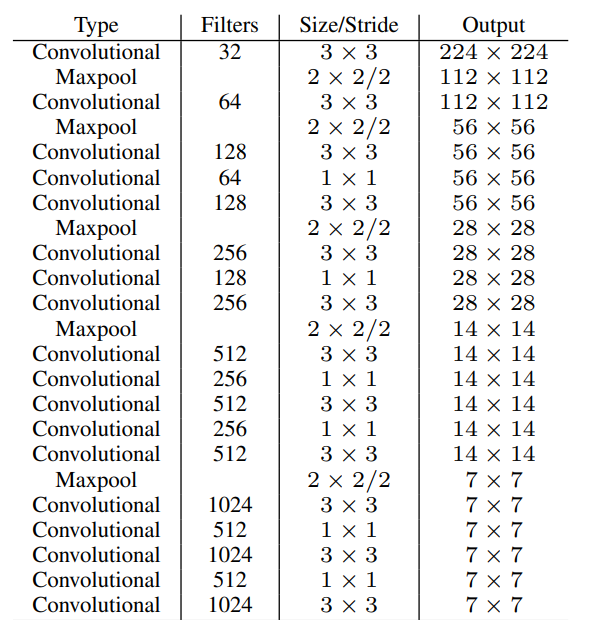

Cette partie de l'architecture est connue Darknet-19. Il est important de mentionner que la section output démontres les dimensions des outputs pour l'utilisation d'une image 224x224, mais que nous allons plutôt utiliser des images de dimensions 416x416. Cependant, cette partie de l'architecture ne fourni pas les outputs de dimension désirés. Dans le but d'utiliser le modèle pour la classification d'images, il faut rajouter une convolution 1x1 suit d'un average pooling et d'une layer de softmax. Dans le cas de la détection d'objets, nous voulons plutôt ajouter une convolution 3x3 avec 1024 filters suivit d'une convolution 1x1 avec 125 filters, ce qui nous donne une sortie de 13x13x125. Les deux premières dimensions (13x13) représente les zones de détections alors que la dernière détection représente la détection de cette zone. La valeur de 125 provient du fait qu'une prédiction pour une boite englobante est de 25 paramètres, soit 20 pour la classification et 5 pour la confiance, x, y, w et h.

In [ ]:
yolov2_architecture = [
    (3, 32, 1, 1),
    "Max Pooling",
    (3, 64, 1, 1),
    "Max Pooling",
    (3, 128, 1, 1),
    (1, 64, 1, 0),
    (3, 128, 1, 1),
    "Max Pooling",
    (3, 256, 1, 1),
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    "Max Pooling",
    (3, 512, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "Max Pooling",
    (3, 1024, 1, 1),
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
    (1, 125, 1, 0),
] 

In [ ]:
class CNNLayer(nn.Module):
  def __init__(self, in_channels, kernel_size, out_channels, stride, padding):
    super(CNNLayer, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    self.batchnorm = nn.BatchNorm2d(out_channels)
    self.activation = nn. LeakyReLU(0.1)

  def forward(self, x):
    return self.activation(self.batchnorm(self.conv(x)))

In [ ]:
class YoloV2(nn.Module):
  def __init__(self, conv_config = yolov2_architecture, num_classes = 20):
    super(YoloV2, self).__init__()
    self.conv_config = conv_config
    self.num_classes = num_classes
    self.in_channels = 3
    self.conv_net = self._init_conv_net()

  def forward(self, x):
    out = self.conv_net(x)
    out = out.reshape(out.shape[0], 5, self.num_classes + 5, out.shape[2], out.shape[3]).permute(0, 1, 3, 4, 2)
    return out

  #Initialisation de la partie convultionnelle du modèle en fonction de la configuration
  def _init_conv_net(self):
    layers = []
    in_channels = self.in_channels
    conv_config = copy.deepcopy(self.conv_config)

    for layer in conv_config :
      if type(layer) == tuple:
        layers += [CNNLayer(
            in_channels = in_channels,
            kernel_size = layer[0],
            out_channels = layer[1],
            stride = layer[2],
            padding = layer[3], 
            )]
        in_channels = layer[1]
      elif type(layer) == str:
        layers += [nn.MaxPool2d(kernel_size=2, stride = 2)]
      
      elif type(layer) == list:
        num_reps = layer[len(layer)-1]
        layer.remove(num_reps)

        for _ in range(num_reps):
          for i in layer:
            layers += [CNNLayer(
              in_channels = in_channels,
              kernel_size = i[0],
              out_channels = i[1],
              stride = i[2],
              padding = i[3], 
            )]

            in_channels = i[1]

    return nn.Sequential(*layers) 

###Loss Function

La fonction de perte pour YoloV2 est très similaire à celle de YoloV1. En effet, elle calcule quatres loss différentes pour la classification, la présence d'objet, l'absence d'objet et les dimensions des boites englobantes. Cependant la forme des prédictions est légèrement différentes et doit être prise en compte. Avec l'utilisation des anchors boxes, nous devons utilisé les fomules ci-dessous :

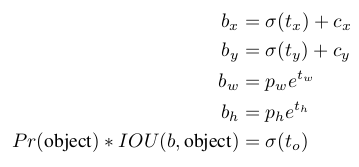

Notamment, la fonction sigmoid s'assure que le point milieu (x, y) des boîtes sont bel et bien au sein de la cellule correspondante en délimitant leur valeur à l'échelle [0, 1]. De plus, le paramètre p permet de calculer les dimensions (w, h) en fonction des dimensions d'ancrage précédentes, affectant ainsi les données en considérant les informations précédemment encodées dans le modèle.

In [ ]:
class YoloLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.entropy = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()

        # Constants signifying how much to pay for each respective part of the loss
        self.lambda_class = 1
        self.lambda_noobj = 10
        self.lambda_obj = 1
        self.lambda_box = 10

    def forward(self, predictions, target, anchors):
        # Check where there is and isn't an object
        obj = target[..., 0] == 1
        noobj = target[..., 0] == 0

        # no object loss
        no_object_loss = self.bce(
            predictions[..., 0:1][noobj], (target[..., 0:1][noobj]),
        )

        # object loss
        anchors = anchors.reshape(1, 5, 1, 1, 2)
        box_preds = torch.cat([self.sigmoid(predictions[..., 1:3]), torch.exp(predictions[..., 3:5]) * anchors], dim=-1)
        ious = intersection_over_union(box_preds[obj], target[..., 1:5][obj]).detach()
        object_loss = self.mse(self.sigmoid(predictions[..., 0:1][obj]), ious * target[..., 0:1][obj])

        # box coordinate loss
        predictions[..., 1:3] = self.sigmoid(predictions[..., 1:3])  # x, y
        target[..., 3:5] = torch.log((1e-16 + target[..., 3:5] / anchors))  # w, h
        box_loss = self.mse(predictions[..., 1:5][obj], target[..., 1:5][obj])

        # class loss
        class_loss = self.entropy(
            (predictions[..., 5:][obj]), (target[..., 5][obj].long()),
        )

        return (
            self.lambda_box * box_loss
            + self.lambda_obj * object_loss
            + self.lambda_noobj * no_object_loss
            + self.lambda_class * class_loss
        )

### Training

In [ ]:
def get_bboxes_yolov2(loader, model, iou_threshold = 0.45, threshold = 0.5, train = False, optimizer = None, loss_fn = None ,pred_format="cells", box_format="midpoint", device="cuda"):
    all_pred_boxes = []
    all_true_boxes = []

    DEVICE = "cuda" if torch.cuda.is_available else "cpu"
    mean_losses = []
    model=model.cuda()

    if train : 
      model.train()
    else :
      model.eval()

    startTime = time.time()
    num_iterations = len(loader)
    i = 1

    for x, y in loader:
        if train : 
          print("\rTraining :", end='')
        else : 
          print("\rValidation :", end='')
        print(f"  {int(i/num_iterations*100)}% -- {i}/{num_iterations} iterations -- {timeSince(startTime)}", end = '')
        i += 1
        x, y= x.to(DEVICE), y.to(DEVICE)
        scaled_anchors = torch.tensor(anchors).to(device) * torch.tensor(13)
        predictions = model(x)
        predictions_copy, y_copy = predictions.clone(), y.clone()
        loss = loss_fn(predictions, y, scaled_anchors)
        mean_losses.append(loss.item())
        if train :
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes_with_anchors(y_copy, scaled_anchors, S=13, is_preds=False)
        bboxes = cellboxes_to_boxes_with_anchors(predictions_copy, scaled_anchors, S=13, is_preds=True)
        for idx in range(batch_size):
          #ici nous pourrions utiliser notre fonction nms comme nous avons utilisé pour yolov1,
          # cependant, cette fonction n'est pas super optimizer et il est beaucoup plus efficace d'utiliser celle de pytorch
          #notre fonction :
            # nms_boxes = nms(bboxes[idx], iou_threshold=iou_threshold, threshold=threshold, box_format=box_format)
          #Celle de pytorch : 
            bboxes_as_tensor = torch.tensor(bboxes)[idx]
            idxs = bboxes_as_tensor[..., 0]
            scores = bboxes_as_tensor[...,1]
            boxes = torchvision.ops.box_convert(bboxes_as_tensor[...,2:], 'cxcywh', 'xyxy')
            nms_boxes_indices = torchvision.ops.batched_nms(boxes, scores, idxs, iou_threshold)
            nms_boxes = bboxes_as_tensor[nms_boxes_indices].tolist()
            

            for nms_box in nms_boxes:
              if nms_box[1] > threshold:
                all_pred_boxes.append(nms_box)

            for box in true_bboxes[idx]:
                if box[1] > threshold:
                    all_true_boxes.append(box)
        del x
        del y
    
    print("")
    average_mean_loss = sum(mean_losses)/len(mean_losses)

    return all_pred_boxes, all_true_boxes, average_mean_loss

In [ ]:
def trainYoloV2(dataset, n_epochs = 50, learning_rate = 2e-3, batch_size = 16, split_size = 7, load_model = False, load_file = "my_checkpoint.pth.tar"):
    torch.backends.cudnn.benchmark = True
    DEVICE = "cuda" if torch.cuda.is_available else "cpu"

    seed = 123
    torch.manual_seed(seed)

    # Initialise model, optimizer and loss function
    model = YoloV2().to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=learning_rate,
    )
    loss_fn = YoloLoss()

    # Separate the training set into training and validation set   
    len_train = int(len(dataset)*0.8)
    len_val = len(dataset) - len_train
    dataset_train, dataset_val = random_split(dataset, [len_train, len_val])
    train_loader = DataLoader(
        dataset=dataset_train,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=True,
    )
    val_loader = DataLoader(
        dataset=dataset_val,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=True,
    )
    
    logger = Logger()

    start_epoch = 0
    if load_model:
        load_checkpoint( model, optimizer, logger, load_file)
        start_epoch = len(logger.losses_train)
    
    for epoch in range(start_epoch, n_epochs + start_epoch):
        print(f"---EPOCH {epoch}---")
        pred_boxes, target_boxes, loss_train = get_bboxes_yolov2(
            train_loader, model, train = True, optimizer = optimizer, loss_fn = loss_fn
        )
        pred_boxes_val, target_boxes_val, loss_val = get_bboxes_yolov2(
            val_loader, model, train = False, loss_fn = loss_fn
        )

        mean_avg_prec_train = map(pred_boxes, target_boxes)
        check_class_accuracy(model, train_loader)
        mean_avg_prec_val = map(pred_boxes_val, target_boxes_val)

        logger.log(accuracy_train=mean_avg_prec_train, loss_train=loss_train, accuracy_val=mean_avg_prec_val, loss_val=loss_val)
        
        print(f"training set loss: {loss_train:.4f}\t\t\tvalidation set loss: {loss_val:.4f}")
        print(f"training set accuracy: {mean_avg_prec_train}t\tvalidation set accuracy: {mean_avg_prec_val}")
    
    print("--Training Complete--")
    return model, logger, optimizer

###Expérimentation

Dans cette section expérimentation, nous avons décidé d'utiliser une approche similaire à ce que nous avons fait avec YoloV1. En effet, nous allons entrainer notre modèle sur les deux jeux de données PascalVOC 2007 et 2012. Pour chacun de ces jeux de données, nous allons utiliser deux taux d'apprentissage. Le premier sera de 1e-4, un taux similaire à celui utilisé avec YoloV1. Cela nous permettra de faire une comparaison entre les deux modèles. Par la suite, le deuxième taux d'apprentissage sera celui utilisé dans l'article, soit de 10e-3 pour les 60 premières epochs, 10e-4 pour les 40 epochs suivantes et 10e-5 jusqu'à la fin de l'entrainement. Les modèles ont été entrainés sur un total de 160 epochs avec un batch size de 16.

Additionnellement, nous avons ajouté une nouvelle mesure pour la comparaison des modèles. En plus de regarder le Mean Average Precision, nous pouvons maintenant aussi voir les trois mesures suivantes : 


*   **Class accuracy** : Métrique pour la classification des objets
*   **Object accuracy** : pourcentage des objets détectés. Autrement dit, 100% si tous les objets sont détectés. Si un objet est détecté alors qu'il n'y en a pas, cela n'affectra pas cette métrique.
*   **No object accuracy** : pourcentage d'absence d'objects détectés. Il s'agit donc de la métrique qui pénalise lorsqu'il objet est détecté alors qu'il n'y a pas d'objet.

Nous pouvons donc commencer par regarder nos résultats avec le dataset 2007 :

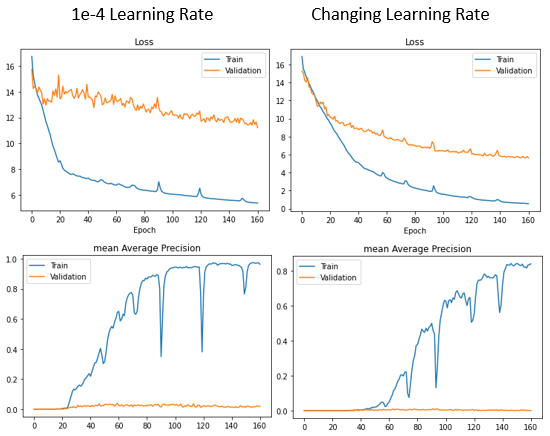

Ces modèles nous permettent d'obtenir les résultats suivants :

Learning rate                 |   1e-4   |  Changing   
------------------------------|----------|--------
**Loss**                      |  5.3698  |  0.5455   
**mAP**                       |  0.9636  |  0.8412 
**Class accuracy**            |  100%    |  100%
**No Object accuracy**        |  99.98%  |  99.99%
**Object accuracy**           |  97.64%  |  86.36%

Nous pouvons donc rapidement remarquer la différence principale entre les deux modèles. L'utilisation d'un très petit learning rate nous permet d'obtenir une très bonne valeur mAP et Objet accuracy avec environ 97% dans les deux cas. Au cas contraire, le learning rate de l'article nous permet d'obtenir une valeur de la loss 10 fois plus petite, mais ne performe pas aussi bien que le premier modèle. Cette différence est probablement dût au fait que notre loss function priorise grandement le no object accuracy dans le but de ne pas détecter des objets qui n'existe pas. En utilisant un taux d'apprentissage de 10e-3 ou 1e-2 pour les premiers 60 epochs, le modèle minimise extrèmement sa loss function en accordant beaucoup plus d'importance à la no object accuracy plutôt qu'à l'object accuracy. Selon nous il serait donc peut-être possible d'obtenir des meilleurs résultats avec ce type de taux d'apprentissage si nous modifions l'importance accodé à chaque partie de la loss function ou si nous entrainions plus longtemps, car l'accuracy continuait à augmenter jusqu'à la tout dernière dernière epoch.

Autre que cela, nous pouvons remarque que le Class accuracy est de 100% et le No Object accuracy est de 99.9%. Ce qui sont d'excellente valeur, nous pouvons donc dire que si un objet est détecté, nous sommes certain à 99.9% qu'il s'agit bien d'un objet et certain à 100% de la classe associée à cet objet. Cependant, cela est seulement vrai pour l'ensemble d'entrainement, nous arrivons encore dans le même problème qu'avec Yolov1, notre modèle ne performe pas sur l'ensemble de validation.

Nous avons ensuite entrainé deux modèles sur le jeu de donnée 2012 :

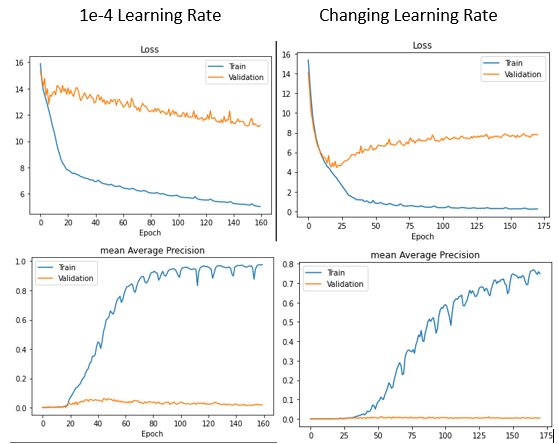

Ces modèles nous permettent d'obtenir les résultats suivants :

Learning rate                 |   1e-4   |  Changing   
------------------------------|----------|--------
**Loss**                      |  5.0374  |  0.2398   
**mAP**                       |  0.9765  |  0.7487 
**Class accuracy**            |  100%    |  99.96%
**No Object accuracy**        |  99.99%  |  99.99%
**Object accuracy**           |  98.25%  |  80.23%

L'utilisation d'un taux d'apprentissage de 1e-4 sur le jeu de donnée de 2012 nous permet donc d'obtenir les meilleures valeurs mAP et object accuracy pour le moment, soit de 97.65% et 98.25% respectivement. Et cela toujours avec des valeurs de no object accuracy et class accuracy presque parfaites. Nous pouvons aussi remarquer que ces modèles ont les mêmes différences que les modèles précédents avec un très grande différence dans la valeur de la loss observé et de très mauvais résultats sur l'ensemble de validation.

Nous avons à nouveau de la facilité à détecter certains objets correctement lorsque la définition entre celui-ci et son environnement est claire.

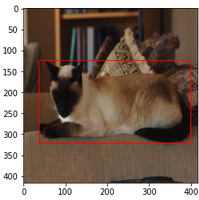

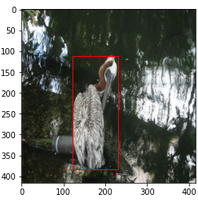

De plus, nous remarquons une aptitude notable de l'algorithme pour les petits objets rapprochés, chose qui valide nos attentes face aux améliorations de YOLOv2.

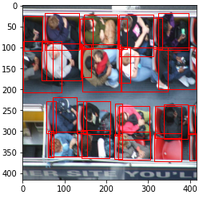

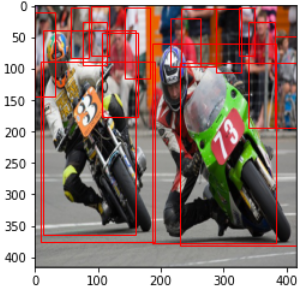

Quelques imperfections sont tout de même notables dans ce contexte spécifique puisque nous observons parfois des boîtes imprécises ou même manquantes, chose qui était présent dans la première version de l'algorithme mais moins fréquente ici.

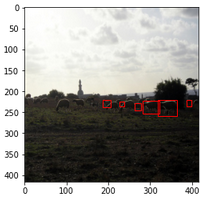

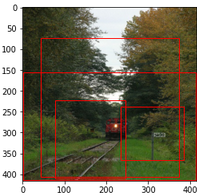

## YOLOv3

###Dataset

Pour le dataset comme pour YOLOv1 on retourne une matrice qui contient les informations nécessaires à la loss fonction. On va charger chaque image du dataset et ses boites. On va réaliser une augmentation sur ces données. Pour chaque boite comme dans YOLOv1 on va l’associer à la cellule qui contient son milieu et en plus on va déterminer quelle boite d'ancrage est la plus proche en réalisant une intersection over union entre les deux.

YOLOv3 transforme l'image, cela comprend le padding pour qu'elle soit de taile 416*416, et l'application de filtre pour changer la brillance le contraste entre autres.

In [ ]:
IMAGE_SIZE = 416
scale = 1.1
train_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
        A.PadIfNeeded(
            min_height=int(IMAGE_SIZE * scale),
            min_width=int(IMAGE_SIZE * scale),
            border_mode=cv2.BORDER_CONSTANT,
        ),
        A.RandomCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
        A.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.6, p=0.4),
        A.OneOf(
            [
                A.ShiftScaleRotate(
                    rotate_limit=20, p=0.5, border_mode=cv2.BORDER_CONSTANT
                ),
                A.IAAAffine(shear=15, p=0.5, mode="constant"),
            ],
            p=1.0,
        ),
        A.HorizontalFlip(p=0.5),
        A.Blur(p=0.1),
        A.CLAHE(p=0.1),
        A.Posterize(p=0.1),
        A.ToGray(p=0.1),
        A.ChannelShuffle(p=0.05),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[],),
)

In [ ]:
class PascalVOC_DataSet(torch.utils.data.Dataset):
  def __init__(self, anchors, S=[13, 26, 52], test = False,C=20):
    self.classes = []
    self.transform = test_transforms
    self.image_set = "val" if test else "train"
    self.dataset = torchvision.datasets.VOCDetection(root = "./", year = '2007', image_set = "train", download = True)
    self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2])  # for all 3 scales
    self.num_anchors = self.anchors.shape[0]
    self.num_anchors_per_scale = self.num_anchors // 3
    self.S = S # grid size
    self.C = C # number of classes
    self.ignore_iou_thresh = 0.5
    
  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, index):
    image, labels = self.dataset[index]
    image = numpy.array(image.convert("RGB"))

    # generate bounding boxes from the labels
    bounding_boxes = []
    size = labels["annotation"]["size"]
    for obj in labels["annotation"]["object"]:
      bounding_box = []
      obj_coords = obj["bndbox"]
      bounding_box.append(((float(obj_coords["xmin"]) + float(obj_coords["xmax"])) / 2  - 1.0)  / float(size["width"]))  # x
      bounding_box.append(((float(obj_coords["ymin"]) + float(obj_coords["ymax"])) / 2  - 1.0) / float(size["height"]))  # y
      bounding_box.append((float(obj_coords["xmax"]) - float(obj_coords["xmin"])) / float(size["width"])) # width
      bounding_box.append((float(obj_coords["ymax"]) - float(obj_coords["ymin"])) / float(size["height"])) # height
      bounding_box.append(obj["name"]) # class_label
      bounding_boxes.append(bounding_box)
    
    #Transform data
    augmentations = self.transform(image=image, bboxes=bounding_boxes)
    image = augmentations["image"]
    bounding_boxes = augmentations["bboxes"]

    # convert labels to matrix of target shape (num_anchors, S, S, 6)
    label_matrix = [torch.zeros((self.num_anchors // 3, S, S, 6)) for S in self.S] # p_o, x, y, w, h, c
    for box in bounding_boxes:

      # sort anchors by their iou wrt. the bbox
      iou_anchors = iou_width_height(torch.tensor(box[2:4]), self.anchors)
      anchor_indices = iou_anchors.argsort(descending=True, dim=0)
      x, y, width, height, class_label  = box 
      has_anchor = [False] * 3

      for anchor_idx in anchor_indices:
        scale_idx = anchor_idx // self.num_anchors_per_scale # which scale ? 0,1,2
        anchor_on_scale = anchor_idx % self.num_anchors_per_scale # wich anchor ? 0,1,2
        S = self.S[scale_idx]
        # get the indexes of the cell
        i, j = int(S * y), int(S * x)

        # check if anchor is taken
        anchor_taken = int(label_matrix[scale_idx][anchor_on_scale, i, j, 0])
        if( (not anchor_taken) and (not has_anchor[scale_idx])):
          label_matrix[scale_idx][anchor_on_scale, i, j, 0] = 1
          # get label content relative to the cell at (i, j)
          x_cell, y_cell = S * x - j, S * y - i  # both between [0,1]
          width_cell, height_cell = (width * S,height * S, )  # can be greater than 1 since it's relative to cell
          # store label content in matrix
          box_coordinates = torch.tensor([x_cell, y_cell, width_cell, height_cell])

          label_matrix[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
          

          if class_label not in self.classes :
            self.classes.append(class_label)
          label_matrix[scale_idx][anchor_on_scale, i, j, 5]= self.classes.index(class_label)
          has_anchor[scale_idx] = True
        
        elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh:
          label_matrix[scale_idx][anchor_on_scale, i, j, 0] = -1  # ignore prediction
      
    return image, tuple(label_matrix)

In [ ]:
anchors = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
]  

In [ ]:
dataset_train_v3 = PascalVOC_DataSet(anchors)
#dataset_test = PascalVOC_DataSet(test=True)

In [ ]:
print(f"The Trainning dataset containt {len(dataset_train_v3)} examples")

###Architecture Model

Nous allons maintenant nous intéresser au amélioration apporter par l’article YOLOv3: An Incremental Improvement. 
Dans cette article plusieurs points d’amélioration sont apporter au modèle de YOLO originale. 
YOLO v3 se base sur le réseau de DarkNET-53. Et est pré entrainer sur Imagenet comme dans YOLOv1. 
Yolov3 contient 53 layer de convolution contre 24 pour YOLOv1.

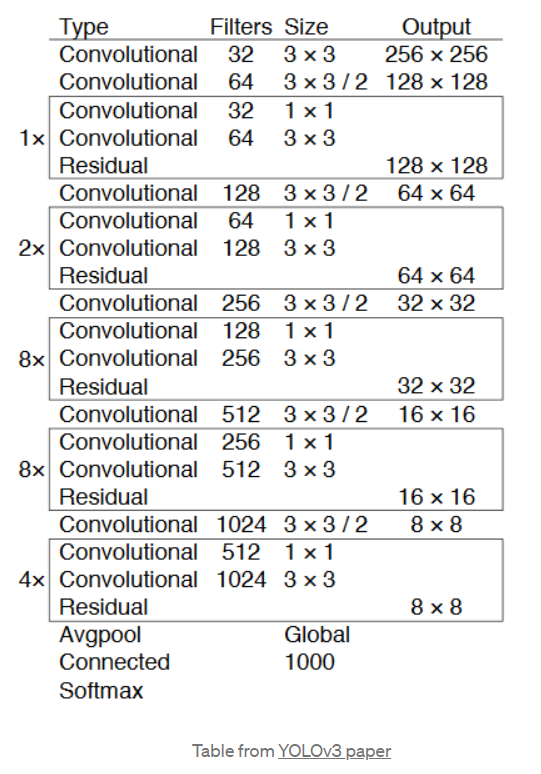


YOLO v3 conserve le même système de grille que le YOLO original. Mais la taille de la grille n’est pas la même, et le nombre non plus. En effet YOLOv3 réalise 3 prédictions avec 3 différente taille de grille.
La raison pour cela est que les gros objets seront mieux détectés si chaque cellule est plus grande et inversement pour les petits objets.


YOLOv3 utilise des « anchor boxes », des boites de taille prédéfinies qui servent de base à la prédiction comme dans YOLOv2. Les tailles des « anchor boxes » suivent également la taille des cellules. Au total YOLOv3 utilise 9 « anchor box » de tailles différentes,  3 pour chaque taille de grille. 

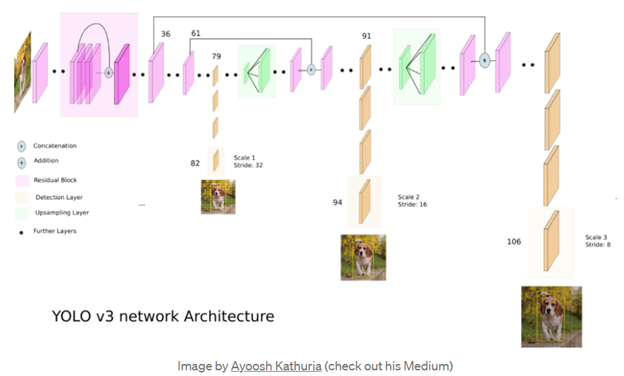

Les layers de DrckNet53 sont suivis des trois chemins vers les différentes tailles de grille. 
Après les deux premières prédictions, on a un upsampling layer qui permet de doubler la taille des features de sortie de la prédiction et de les concaténer avec la sortie des layers de convolution.  

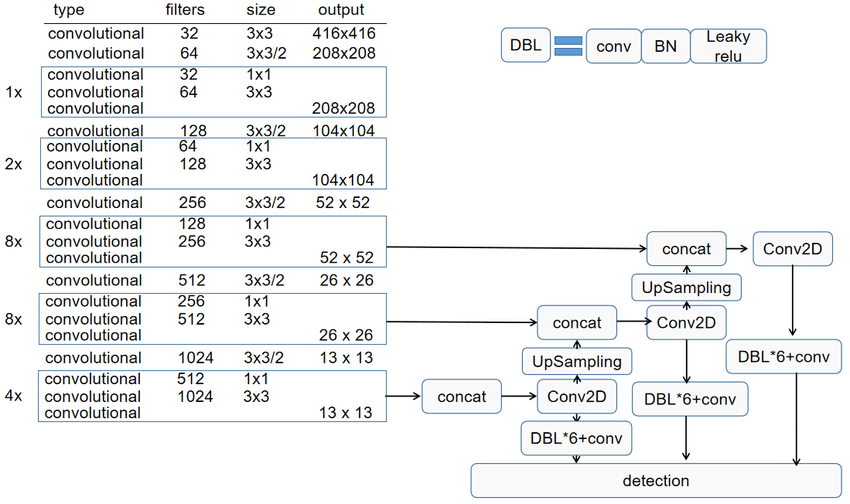

source: https://www.researchgate.net/figure/YOLO-v3-network-structure_fig1_337083419

Voici les données pour la configuration du modèles.
Les tuples indiquent les layers de convolution tels que (filters, kernel_size, stride)

"B" signifie residual block suivi du nombre de répétition 

"S" indique la prédiction des boites 

"U" est pour upsampling et la concaténation

In [ ]:
config = [
    #partie Darknet
    (32, 3, 1),
    (64, 3, 2),
    ["B", 1],
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 8],
    (512, 3, 2),
    ["B", 8], 
    (1024, 3, 2),
    ["B", 4],

    #partie YOLO
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S",
]

In [ ]:
class CNNBlockActivation(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlockActivation, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leaky(self.bn(self.conv(x)))


class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=True, **kwargs)
    def forward(self, x):
      return self.conv(x)

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, channels, use_residual=True, num_repeats=1):
        super(ResidualBlock, self).__init__()
        self.layers = nn.ModuleList()
        for repeat in range(num_repeats):
            self.layers += [
                nn.Sequential(
                    CNNBlockActivation(channels, channels // 2, kernel_size=1),
                    CNNBlockActivation(channels // 2, channels, kernel_size=3, padding=1),
                )
            ]

        self.use_residual = use_residual
        self.num_repeats = num_repeats

  def forward(self, x):
      for layer in self.layers:
          if self.use_residual:
              x = x + layer(x)
          else:
              x = layer(x)

      return x

In [ ]:
class ScalePrediction(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pred = nn.Sequential(
            CNNBlockActivation(in_channels, 2 * in_channels, kernel_size=3, padding=1),
            #3 anchor boxes par cellule * (num_class + 5 parameters of bounding box) 
            CNNBlock(2 * in_channels, 3*(num_classes + 5), kernel_size=1),
        )
        self.num_classes = num_classes

    def forward(self, x):
        return (
            self.pred(x)
            .reshape(x.shape[0], 3, self.num_classes + 5, x.shape[2], x.shape[3])
            .permute(0, 1, 3, 4, 2)
            # N* 3* grid_dim(=13)*grid_dim(=13) *5+Num_classes
        )


In [ ]:
class YOLOv3(nn.Module):
    def __init__(self, in_channels=3, num_classes=80):
        super().__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.layers = self._create_conv_layers()

    def forward(self, x):
        outputs = []  # for each scale
        route_connections = []
        for layer in self.layers:
            if isinstance(layer, ScalePrediction):
                outputs.append(layer(x))
                continue

            x = layer(x)

            #Comme dans l'image du reseau ci dessus c'est la sortie des 8 répétions 
            #des blocs résiduel qui servent plus tard pour la concaténation 
            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                route_connections.append(x)

            elif isinstance(layer, nn.Upsample):
                #On utilise la dernière route ajouté
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()

        return outputs

    def _create_conv_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels

        for module in config:
            if isinstance(module, tuple):
                out_channels, kernel_size, stride = module
                layers.append(
                    CNNBlockActivation(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=1 if kernel_size == 3 else 0,
                    )
                )
                in_channels = out_channels

            elif isinstance(module, list):
                num_repeats = module[1]
                layers.append(ResidualBlock(in_channels, num_repeats=num_repeats,))

            elif isinstance(module, str):
                if module == "S":
                    layers += [
                        ResidualBlock(in_channels, use_residual=False, num_repeats=1),
                        CNNBlockActivation(in_channels, in_channels // 2, kernel_size=1),
                        ScalePrediction(in_channels // 2, num_classes=self.num_classes),
                    ]
                    in_channels = in_channels // 2

                elif module == "U":
                    layers.append(nn.Upsample(scale_factor=2),)
                    in_channels = in_channels * 3

        return layers


###Loss function

La loss function de YOLOv3 est la même que celle de YOLOv2.

Elle sera appeller 3 fois comme on réalise trois prédiction sur différentes echelles.

In [ ]:
class YoloLossv3(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.entropy = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()

        # Constants signifying how much to pay for each respective part of the loss
        self.lambda_class = 1
        self.lambda_noobj = 10
        self.lambda_obj = 1
        self.lambda_box = 10

    def forward(self, predictions, target, anchors):
        # Check where there is and isn't an object
        obj = target[..., 0] == 1
        noobj = target[..., 0] == 0

        # no object loss
        no_object_loss = self.bce(
            predictions[..., 0:1][noobj], (target[..., 0:1][noobj]),
        )

        # object loss
        anchors = anchors.reshape(1, 3, 1, 1, 2)
        box_preds = torch.cat([self.sigmoid(predictions[..., 1:3]), torch.exp(predictions[..., 3:5]) * anchors], dim=-1)
        ious = intersection_over_union(box_preds[obj], target[..., 1:5][obj]).detach()
        object_loss = self.mse(self.sigmoid(predictions[..., 0:1][obj]), ious * target[..., 0:1][obj])

        # box coordinate loss
        predictions[..., 1:3] = self.sigmoid(predictions[..., 1:3])  # x, y
        target[..., 3:5] = torch.log((1e-16 + target[..., 3:5] / anchors))  # w, h
        box_loss = self.mse(predictions[..., 1:5][obj], target[..., 1:5][obj])

        # class loss
        class_loss = self.entropy(
            (predictions[..., 5:][obj]), (target[..., 5][obj].long()),
        )

        return (
            self.lambda_box * box_loss
            + self.lambda_obj * object_loss
            + self.lambda_noobj * no_object_loss
            + self.lambda_class * class_loss
        )

###Training

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available else "cpu"

In [ ]:
def cells_to_bboxes(predictions, anchors, S, is_preds=True):
    BATCH_SIZE = predictions.shape[0]
    num_anchors = len(anchors)
    box_predictions = predictions[..., 1:5]
    if is_preds:
        anchors = anchors.reshape(1, len(anchors), 1, 1, 2)
        box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2])
        box_predictions[..., 2:] = torch.exp(box_predictions[..., 2:]) * anchors
        scores = torch.sigmoid(predictions[..., 0:1])
        best_class = torch.argmax(predictions[..., 5:], dim=-1).unsqueeze(-1)
    else:
        scores = predictions[..., 0:1]
        best_class = predictions[..., 5:6]

    cell_indices = (
        torch.arange(S)
        .repeat(predictions.shape[0], 3, S, 1)
        .unsqueeze(-1)
        .to(predictions.device)
    )
    x = 1 / S * (box_predictions[..., 0:1] + cell_indices)
    y = 1 / S * (box_predictions[..., 1:2] + cell_indices.permute(0, 1, 3, 2, 4))
    w_h = 1 / S * box_predictions[..., 2:4]
    converted_bboxes = torch.cat((best_class, scores, x, y, w_h), dim=-1).reshape(BATCH_SIZE, num_anchors * S * S, 6)
    return converted_bboxes.tolist()

In [ ]:
def check_class_accuracy_v3(model, loader, threshold):
    model.eval()
    tot_class_preds, correct_class = 0, 0
    tot_noobj, correct_noobj = 0, 0
    tot_obj, correct_obj = 0, 0

    for x, y in loader:
        x = x.to(DEVICE)
        with torch.no_grad():
            out = model(x)
        for i in range(3):
            y[i] = y[i].to(DEVICE)
            obj = y[i][..., 0] == 1 # in paper this is Iobj_i
            noobj = y[i][..., 0] == 0  # in paper this is Iobj_i

            correct_class += torch.sum(
                torch.argmax(out[i][..., 5:][obj], dim=-1) == y[i][..., 5][obj]
            )
            tot_class_preds += torch.sum(obj)

            obj_preds = torch.sigmoid(out[i][..., 0]) > threshold
            correct_obj += torch.sum(obj_preds[obj] == y[i][..., 0][obj])
            tot_obj += torch.sum(obj)

            correct_noobj += torch.sum(obj_preds[noobj] == y[i][..., 0][noobj])
            tot_noobj += torch.sum(noobj)

    print(f"Class accuracy is: {(correct_class/(tot_class_preds+1e-16))*100:2f}%")
    print(f"No obj accuracy is: {(correct_noobj/(tot_noobj+1e-16))*100:2f}%")
    print(f"Obj accuracy is: {(correct_obj/(tot_obj+1e-16))*100:2f}%")
    model.train()

In [ ]:
def get_evaluation_bboxes(loader, model, iou_threshold, anchors, threshold, batch_size, box_format="midpoint", device="cuda"):
    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0
    all_pred_boxes = []
    all_true_boxes = []
    for batch_idx, (x, labels) in enumerate(tqdm(loader)):
        x = x.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        bboxes = [[] for _ in range(batch_size)]
        for i in range(3):
            S = predictions[i].shape[2]
            anchor = torch.tensor([*anchors[i]]).to(device) * S
            boxes_scale_i = cells_to_bboxes(
                predictions[i], anchor, S=S, is_preds=True
            )
            for idx, (box) in enumerate(boxes_scale_i):
                bboxes[idx] += box

        true_bboxes = cells_to_bboxes(
            labels[2], anchor, S=S, is_preds=False
        )

        for idx in range(batch_size):
            bboxes_as_tensor = torch.tensor(bboxes)[idx]
            idxs = bboxes_as_tensor[..., 0]
            scores = bboxes_as_tensor[...,1]
            boxes = torchvision.ops.box_convert(bboxes_as_tensor[...,2:], 'cxcywh', 'xyxy')
            nms_boxes_indices = torchvision.ops.batched_nms(boxes, scores, idxs, iou_threshold)
            nms_boxes = bboxes_as_tensor[nms_boxes_indices].tolist()


            
            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes

In [ ]:
def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20):

    average_precisions = []

    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:])
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

In [ ]:
IMAGE_SIZE = 416
S = [IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8]

scaler = torch.cuda.amp.GradScaler()

def train_yolov3(loader, model, iou_threshold = 0.45, threshold = 0.5, train = False, optimizer = None, loss_fn = None ,pred_format="cells", box_format="midpoint", device="cuda"):
    all_pred_boxes = []
    all_true_boxes = []

    DEVICE = "cuda" if torch.cuda.is_available else "cpu"
    mean_losses = []
    model=model.cuda()

    if train : 
      model.train()
    else :
      model.eval()

    startTime = time.time()
    num_iterations = len(loader)
    i = 1

    for x, y in loader:
        if train : 
          print("\rTraining :", end='')
        else : 
          print("\rValidation :", end='')
        print(f"  {int(i/num_iterations*100)}% -- {i}/{num_iterations} iterations -- {timeSince(startTime)}", end = '')
        i += 1
        x = x.to(DEVICE)
        y0 = y[0].to(DEVICE)
        y1 = y[1].to(DEVICE)
        y2 = y[2].to(DEVICE)

        scaled_anchors = (torch.tensor(anchors) * torch.tensor(S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)).to(DEVICE)
        
        with torch.cuda.amp.autocast():
          predictions = model(x)
          loss = loss_fn(predictions[0], y0, scaled_anchors[0]) + loss_fn(predictions[1], y1, scaled_anchors[1]) + loss_fn(predictions[2], y2, scaled_anchors[2])

        mean_losses.append(loss.item())

        if train :
          optimizer.zero_grad()
          scaler.scale(loss).backward()
          scaler.step(optimizer)
          scaler.update()
        del x
        del y
    
    print("")
    average_mean_loss = sum(mean_losses)/len(mean_losses)

    return average_mean_loss

In [ ]:
def trainYoloV3(dataset, n_epochs = 50, learning_rate = 1e-4, batch_size = 16, split_size = 7, load_model = False, load_file = "my_checkpoint_yolov3.pth.tar"):
    torch.backends.cudnn.benchmark = True
    DEVICE = "cuda" if torch.cuda.is_available else "cpu"

    seed = 123
    torch.manual_seed(seed)

    # Initialise model, optimizer and loss function
    model = YOLOv3().to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=learning_rate
    )
    loss_fn = YoloLossv3()

    # Separate the training set into training and validation set   
    len_train = 100 #int(len(dataset)*0.8)
    len_val = len(dataset) - len_train
    dataset_train, dataset_val = random_split(dataset, [len_train, len_val])
    train_loader = DataLoader(
        dataset=dataset_train,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=True,
    )
    val_loader = DataLoader(
        dataset=dataset_val,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=True,
    )
    
    logger = Logger()

    start_epoch = 0
    if load_model:
        load_checkpoint( model, optimizer, logger, load_file)
        start_epoch = len(logger.losses_train)
    
    for epoch in range(start_epoch, n_epochs + start_epoch):
        print(f"---EPOCH {epoch}---")
        loss_train = train_yolov3(train_loader, model,  train = True, optimizer = optimizer, loss_fn = loss_fn)

        #if epoch > 0 and epoch % 3 == 0:
        check_class_accuracy_v3(model, train_loader, threshold=0.05)
        pred_boxes, true_boxes = get_evaluation_bboxes(
            train_loader,
            model,
            iou_threshold=0.5,
            anchors=anchors,
            threshold=0.4,
            batch_size=batch_size,
        )
        mapval = mean_average_precision(
            pred_boxes,
            true_boxes,
            iou_threshold=0.5,
            num_classes=20,
        )
        print(f"MAP: {mapval.item()}")
        model.train()
      
        logger.log(accuracy_train=mapval, loss_train=loss_train)#, accuracy_val=mean_avg_prec_val, loss_val=loss_val)
        
        print(f"training set loss: {loss_train:.4f}")#\t\t\tvalidation set loss: {loss_val:.4f}")
        print(f"training set accuracy: {mapval}")#\t\tvalidation set accuracy: {mean_avg_prec_val}")
    
    print("--Training Complete--")
    return model, logger, optimizer

###Experimentation

Dans cette section expérimentation, nous avons décidé d'utiliser une approche similaire à ce que nous avons fait avec YoloV1 et YoloV2. Entrainement du  modèle va se faire sur les deux jeux de données PascalVOC 2007 et 2012.
Comme précédament nous utiliseront un taux d'apprentissage de 1e-4. Nous ne présenteront pas de courbe pour le map car le temps d'évaluation et de calcul du map est trop important et trop demandant en ressource.

Pour ce qui est des temps 

Résultats obtenus sur PASCALVOC2007 

Ces modèles nous permettent d'obtenir les résultats suivants :

Modele  1e-4                          |   20epochs   |  40 epochs | 60 epochs   
------------------------------          |----------|--------|-----------------
**Loss validation set**                 | 13.6178 |  14.2609| 13.5056  
**mAP validation set**                  |  0.015  |  0.013  | 0.021
**Loss train set**                      |  2.7497 |  1.4349| 1.2920
**mAP train set**                       |  0.26   |  0.82  |0.88
**Class accuracy train set**            | 98.69%  |  99.88%|100.00%
**No Object accuracy train set**        | 98.17%  |  99.38%|99.75%
**Object accuracy train set**           | 35.40%  |  48.97%|49.01%

L'utilisation d'un taux d'apprentissage de 1e-4 sur le jeu de donnée de 2007 nous permet donc d'obtenir le valeurs mAP de 0,88%. Avec des valeurs de no object accuracy à 40 pourcents et de class accuracy et object accuracy presque parfaites. Comme précédament les résultats sur le validation set est vraiment bas on arrive à un palier au bout de 20 epoch seulement ou le map est de 0,015 et la loss de 13.6. Au bout de 60 epochs on observe plus d'amélioration du modèle. Pour essayer d'obtenir de meilleur résultat on a poursuivi le training après 60 epochs avec un learning rate de 1e-5. 


Modele changing lr                   |   100epochs   | 
------------------------------          |----------|
**Loss validation set**                 | 13.9493|  
**mAP validation set**                  |  0.020  |  
**Loss train set**                      |  1.2751 | 
**mAP train set**                       |  0.90   |  
**Class accuracy train set**            | 100.00%  |  
**No Object accuracy train set**        | 99.87%  |  
**Object accuracy train set**           | 49.03%  |  

Cela à permis d'atteindre les 0,90 de map sur le train, de meilleur résultat pourrais être optenue en baissant le learning rate et en entrainant un peu plus longtemps. 


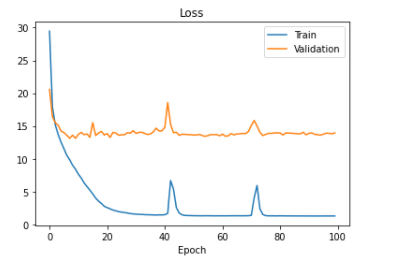

Voici la loss optenue de 0 à 60 epochs avec lr=1e-4 et lr=1e-5 jusqu'à 100 epochs

On à égalelement entrainer avec lr= 1e-4 un batch size de 16  sur PASCALVOC 2012.
On obtient les résultats suivant:

Modele changing lr                   |   60 epochs   | 
------------------------------          |----------|
**Loss validation set**                 | 14.05|  
**mAP validation set**                  |  0.007  |  
**Loss train set**                      | 1.25 | 
**mAP train set**                       | 0.89    |  
**Class accuracy train set**            |  100% |  
**No Object accuracy train set**        |  99.8% |  
**Object accuracy train set**           | 49.74% |  


Une évaluation et calcul de maP prend 2h 20min et 45s par epochs.
Il nous aurait fallut 5 jours 20 heures 45 minutes de plus pour le faire à chaques epochs de l'entrainement.

Le temps d'entrainement par epoch est de 2 minutes 42 le total d'entrainement est de 2 heures 42 minutes.


YOLO V3 semble très à l'aise avec la détection des petits objet rapprochés

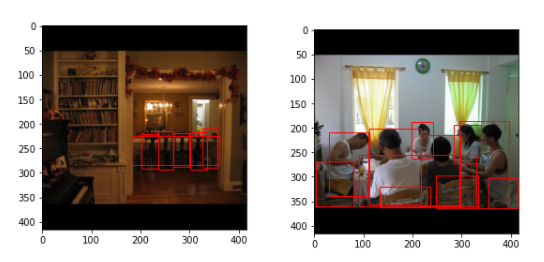

Et avec des objets de différentes taille sur diffèrent plan

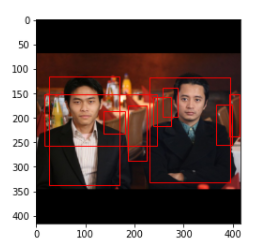

Mais il commet encore des erreurs sur l'image de gauche on peut voir la multitude d'animaux non détectés par YOLOv3 et sur l'image de droite les petites bouteilles du frigo et du rebord de fenêtre ne sont pas détectées.  

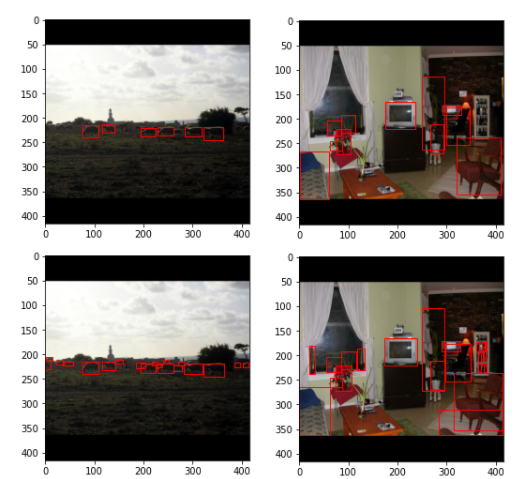